In [4]:
import pandas as pd
import numpy as np
import matplotlib as plt
import geopandas as gpd
from fiona.crs import from_epsg
import pysal as ps
import urllib2
import urllib
from cStringIO import StringIO
import json
from sklearn.cluster import KMeans

%pylab inline

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [530]:
import scipy.stats

## 1) Find the number of businesses in 2010 and 2000. 

In [6]:
!mkdir data
!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip -P data
!wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip -P data

--2016-12-18 19:56:19--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => ‘data/zbp00totals.zip’
Resolving ftp.census.gov... 2610:20:2010:a09:1000::9481:4b23, 148.129.75.35
Connecting to ftp.census.gov|2610:20:2010:a09:1000::9481:4b23|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> EPSV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

zbp00totals.zip     100%[===================>] 613.71K   624KB/s    in 1.0s    

2016-12-18 19:56:22 (624 KB/s) - ‘data/zbp00totals.zip’ saved [628434]

--2016-12-18 19:56:22--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
           => ‘data/zbp10totals.zip’
Resolving ftp.census.gov... 2610:20:2010:a09:1000::9481:4b23, 148.129.75.35
Connecting to ftp.census.gov|2610:20:2010:a09:1000::9481:4b23|:21... connected.
Logg

In [7]:
!unzip data/zbp00totals.zip -d data
!unzip data/zbp10totals.zip -d data

Archive:  data/zbp00totals.zip
  inflating: data/zbp00totals.txt    
Archive:  data/zbp10totals.zip
  inflating: data/zbp10totals.txt    


#### merge 2000 and 2010 data into one dataframe

In [15]:
data_2000 = pd.read_csv('data/zbp00totals.txt')
data_2010 = pd.read_csv('data/zbp10totals.txt')

In [16]:
data_2000.head()

ZIP            NAME EMPFLAG   EMP    QP1      AP  EST
0   501  HOLTSVILLE, NY       A     0      0       0    1
1  1001      AGAWAM, MA     NaN  8042  59833  259661  493
2  1002     AMHERST, MA     NaN  6547  36719  169658  563
3  1003     AMHERST, MA     NaN    82    308    2482   13
4  1004     AMHERST, MA     NaN   717   2049    5826   48

In [17]:
data_2000 = data_2000.drop(['NAME', 'EMPFLAG', 'EMP', 'QP1', 'AP'], axis = 1)
data_2000 = data_2000.rename(columns = {'ZIP' : 'zip' , 'EST' : 2000})
data_2000.head()

zip  2000
0   501     1
1  1001   493
2  1002   563
3  1003    13
4  1004    48

In [18]:
data_2010 = data_2010.drop([u'name', u'empflag', u'emp_nf', u'emp', u'qp1_nf', u'qp1',
                u'ap_nf', u'ap',  u'city', u'stabbr', u'cty_name'], axis = 1)
data_2010 = data_2010.rename(columns = {'est' : 2010})
data_2010.head()

zip  2010
0   501     2
1  1001   448
2  1002   570
3  1003    16
4  1004    21

In [19]:
business = pd.merge(data_2000 , data_2010 , on = 'zip' , how = 'outer')
business.zip = business.zip.astype(int)
business.head()

zip   2000   2010
0   501    1.0    2.0
1  1001  493.0  448.0
2  1002  563.0  570.0
3  1003   13.0   16.0
4  1004   48.0   21.0

## 2) Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile

In [20]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip -P data
!unzip data/application%2Fzip -d data

--2016-12-18 20:01:48--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us... 52.206.68.26
Connecting to data.cityofnewyork.us|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2016-12-18 20:01:48--  https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Reusing existing connection to data.cityofnewyork.us:443.
HTTP request sent, awaiting response... 200 OK
Length: 1514401 (1.4M) [application/octet-stream]
Saving to: ‘data/application%2Fzip’

application%2Fzip   100%[===================>]   1.44M  1.98MB/s    in 0.7s    

2016-12-18 20:01:49 (1.98 MB/s) - ‘data/application%2Fzip’ saved [1514401/1514401]

Archive:  data/application%2Fzip
  inflating: data/ZIP_CODE_040114.shx  
  inflating: data/ZIP_CODE_0401

In [21]:
nyc_shape = gpd.read_file('data/ZIP_CODE_040114.shp')
nyc_shape.head()

AREA BLDGZIP  COUNTY CTY_FIPS  POPULATION   PO_NAME  SHAPE_AREA  \
0  2.269930e+07       0  Queens      081     18681.0   Jamaica         0.0   
1  2.963100e+07       0   Kings      047     62426.0  Brooklyn         0.0   
2  4.197210e+07       0   Kings      047     83866.0  Brooklyn         0.0   
3  2.369863e+07       0   Kings      047     56527.0  Brooklyn         0.0   
4  3.686880e+07       0   Kings      047     72280.0  Brooklyn         0.0   

   SHAPE_LEN STATE ST_FIPS                   URL ZIPCODE  \
0        0.0    NY      36  http://www.usps.com/   11436   
1        0.0    NY      36  http://www.usps.com/   11213   
2        0.0    NY      36  http://www.usps.com/   11212   
3        0.0    NY      36  http://www.usps.com/   11225   
4        0.0    NY      36  http://www.usps.com/   11218   

                                            geometry  
0  POLYGON ((1038098.251871482 188138.3800067157,...  
1  POLYGON ((1001613.712964058 186926.4395172149,...  
2  POLYGON ((1011174.275535807 183696.33770971, 1...  
3  POLYGON ((995908.3654508889 183617.6128015518,...  
4  POLYGON ((991997.1134308875 176307.4958601296,...

In [22]:
nyc_shape.crs = from_epsg(2263)
nyc_shape = nyc_shape.to_crs(epsg=4326)

In [23]:
zipcode_shape = nyc_shape[['AREA' , 'ZIPCODE' , 'geometry']]
zipcode_shape = zipcode_shape.rename(columns = {'ZIPCODE' : 'zip'})
zipcode_shape.head()

AREA    zip                                           geometry
0  2.269930e+07  11436  POLYGON ((-73.80584847647394 40.68290932644246...
1  2.963100e+07  11213  POLYGON ((-73.93739763139813 40.67972958925082...
2  4.197210e+07  11212  POLYGON ((-73.90294132545438 40.67083977590006...
3  2.369863e+07  11225  POLYGON ((-73.95797316043482 40.67065695897565...
4  3.686880e+07  11218  POLYGON ((-73.97208109564257 40.65059658727609...

In [24]:
zipcode_shape.zip = pd.to_numeric(zipcode_shape.zip , errors = 'coerce')
zipcode_shape.zip = zipcode_shape.zip.astype(int)

In [25]:
business = zipcode_shape.merge(business, on = 'zip' ,how = 'left' )

## 3)Find the density of businesses through dividing the number of businesses by the area of the zipcode and show density in two choropleth. Also, show difference in business density as well

#### Calculate business density by area, as density numbers are too small, use log10

In [26]:
business['2000_density'] = np.log10( business[2000] / business.AREA )
business['2010_density'] = np.log10( business[2010] / business.AREA )
business.head()

AREA    zip                                           geometry  \
0  2.269930e+07  11436  POLYGON ((-73.80584847647394 40.68290932644246...   
1  2.963100e+07  11213  POLYGON ((-73.93739763139813 40.67972958925082...   
2  4.197210e+07  11212  POLYGON ((-73.90294132545438 40.67083977590006...   
3  2.369863e+07  11225  POLYGON ((-73.95797316043482 40.67065695897565...   
4  3.686880e+07  11218  POLYGON ((-73.97208109564257 40.65059658727609...   

     2000    2010  2000_density  2010_density  
0    65.0    98.0     -5.543099     -5.364786  
1   477.0   675.0     -4.793228     -4.642443  
2   520.0   699.0     -4.906957     -4.778484  
3   417.0   580.0     -4.754587     -4.611295  
4  1161.0  1474.0     -4.501827     -4.398162

In [27]:
def choropleth(df, column, title, cm = 'OrRd', c_bar = True):
    '''make a color map
    variable explanation:
    df: dataframe
    column: color based on which column
    cm: default by 'OrRd'
    c_bar: show color bar or not
    '''
    
    f, ax = plt.subplots( figsize = (6,6) )
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    df.plot(column = column , colormap = cm ,
            alpha = 0.7 , linewidth = 0.1,
            edgecolor = 'grey' , ax = ax)
    #ax.set_axis_off()
    plt.title( title)
    plt.xlim( -74.3, -73.7)
    plt.ylim( 40.45, 40.95)
    
    #show colorbar 
    if c_bar == True:
        vmin, vmax = min(df[column].values) , max(df[column].values)
        fig = ax.get_figure()
        cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap = cm , norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        fig.colorbar(sm, cax=cax)
    else:
        pass

//anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


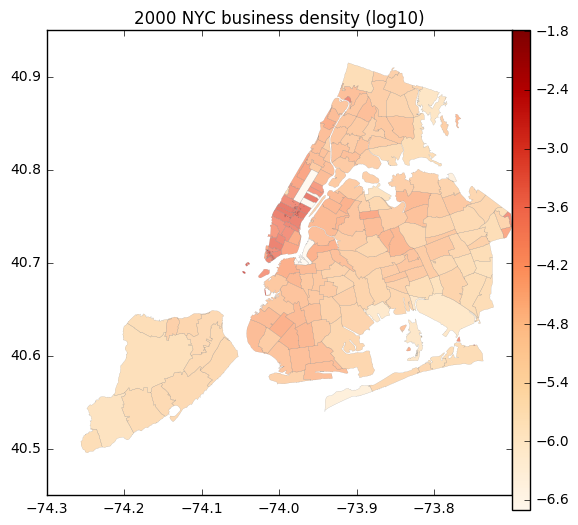

In [28]:
choropleth(df = business , column = '2000_density' ,
          title = '2000 NYC business density (log10)')

#### caption：calculate 2000 business density -- log10( business count in the zipcode/ the zipcode area). The white zipcode on the map is the place without business data. And the dark area in Manhatthan shows there is business concentrated.

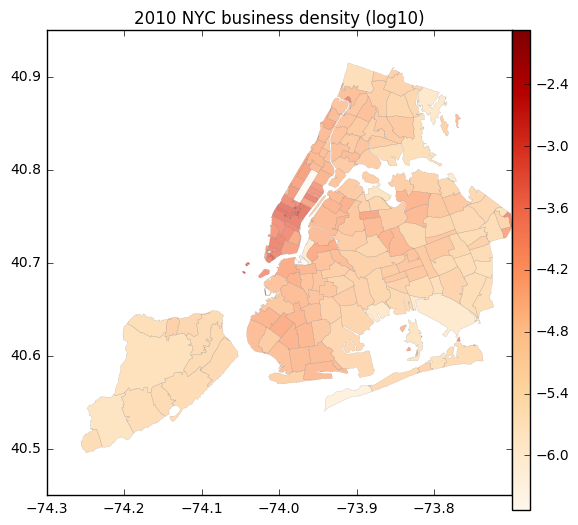

In [29]:
choropleth(df = business , column = '2010_density' ,
          title = '2010 NYC business density (log10)')

#### caption：calculate 2010  business density -- log10( business count in the zipcode/ the zipcode area). The white zipcode on the map is the place without business data. And the dark area in Manhatthan shows there is business concentrated.

#### calculate difference between 2000 and 2010
####  difference of 2010 and 2000 are so small , and some of them is negative, cannot use log, so multiply by 1e6

In [116]:
business['difference'] = ( business[2010] - business[2000] ) / business.AREA *1e6

In [119]:
business.head(3)

AREA    zip                                           geometry  \
0  2.269930e+07  11436  POLYGON ((-73.80584847647394 40.68290932644246...   
1  2.963100e+07  11213  POLYGON ((-73.93739763139813 40.67972958925082...   
2  4.197210e+07  11212  POLYGON ((-73.90294132545438 40.67083977590006...   

    2000   2010  2000_density  2010_density  difference  
0   65.0   98.0     -5.543099     -5.364786    1.453790  
1  477.0  675.0     -4.793228     -4.642443    6.682190  
2  520.0  699.0     -4.906957     -4.778484    4.264737

In [120]:
print 'min difference:' , min(business['difference'])
print 'max difference:' , max(business['difference'])

min difference: -10608.0228589
max difference: 2041.82865713


#### As the range of difference is really wide, and mainly the difference is between 0 and 20. So I use quantiles, to divide difference into 10 groups

In [128]:
lag10 = ps.Quantiles(business['difference'].dropna(), k=10)
lag10

                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <= -215.076               25
-215.076 < x[i] <=   -0.419               25
  -0.419 < x[i] <=    0.684               25
   0.684 < x[i] <=    1.230               25
   1.230 < x[i] <=    2.189               25
   2.189 < x[i] <=    3.812               25
   3.812 < x[i] <=    5.786               25
   5.786 < x[i] <=    8.797               25
   8.797 < x[i] <=   23.270               25
  23.270 < x[i] <= 2041.829               25

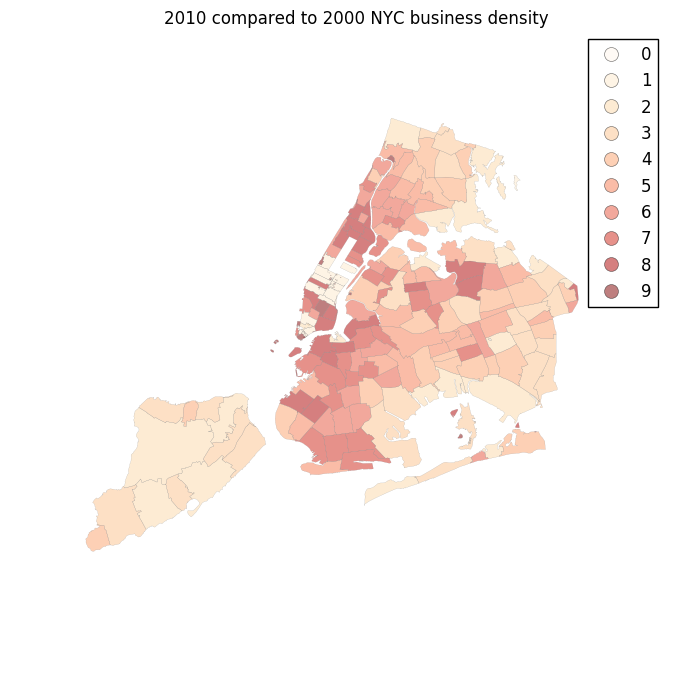

In [136]:
f, ax = plt.subplots(figsize=(8, 8))
business_dropna = business.loc[business['difference'].dropna().index]
business_dropna.assign(cl = lag10.yb).plot(column = 'cl', categorical = True, 
                                    k = 10, cmap = 'OrRd', linewidth = 0.1, ax = ax, 
                                    edgecolor = 'grey', legend = True)
ax.set_axis_off()
plt.title("2010 compared to 2000 NYC business density")

#### Caption: the not shown zipcodes area lack one or both business data in 2000 and 2010, so cannot show difference
#### Group 0 and 1 means, 2010 has less business than 2000. So the 2 lightest groups are where business is decreasing.
#### Group 2 is around 0, means these area business is stable, neither increasing nor decreasing 
#### Group 3 and afterwards, means business in those zipcode area are increasing. The darker the area is, the more business grows.

## 4) Collect census demography data of 2010 and 2000. Extract the median age, population, and racial diversity of each census tract (the diversity measured by the fraction of white population) .

#### Get demography and income data by census tract from CartoDB

In [38]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

#### Extract The Geo identifiers , Total population (Number) , White population (Percentage) , Median age from CARTODB

In [155]:
facilityQuery = '''
SELECT Geo_id2 , Hc01_vc01, Hc01_vc18, Hc02_vc29 
FROM Dec_00_sf1_dp1
'''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
census2000 = pd.DataFrame.from_dict(facilityData['rows'])
census2000 = census2000.rename(columns = {'hc01_vc01' : 'population' , 
                                          'hc01_vc18' : "median_age" ,
                                          'hc02_vc29' : 'white_percentage' })
census2000['geo_id2'] = pd.to_numeric(census2000['geo_id2'], errors = 'coerce')
census2000.head()

geo_id2 population median_age white_percentage
0  36047054300          0        0.0                 
1  36081121100          0        0.0                 
2  36005003700        478       22.0             18.4
3  36005004900        246       30.0             20.7
4  36005005800          5       23.5              0.0

In [156]:
facilityQuery = '''
SELECT Geo_id2 , hd01_s001, hd01_s020, hd02_s078 
FROM dec_10_sf1_sf1dp1
'''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
census2010 = pd.DataFrame.from_dict(facilityData['rows'])
census2010 = census2010.rename(columns = {'hd01_s001' : 'population', 
                                          'hd01_s020' : "median_age",
                                          'hd02_s078' : 'white_percentage' })
census2010['geo_id2'] = pd.to_numeric(census2010['geo_id2'], errors = 'coerce')
census2010.head()

geo_id2 population median_age white_percentage
0  36081038301          0          0                 
1  36005002400          4         38               50
2  36059990200          0          0                 
3  36059990400          0          0                 
4  36007012900       1532       59.8             98.2

## 5) Collect the income data of 2010 and 2000 at the census tract level.

In [152]:
facilityQuery = '''
SELECT Geo_id2 , hc01_vc64
FROM Dec_00_sf3_dp3_with_ann
'''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
income2000 = pd.DataFrame.from_dict(facilityData['rows'])
income2000 = income2000.rename(columns = {'hc01_vc64' : 'income'})

income2000.head()

geo_id2  income
0  36089991900       0
1  36001013703   68929
2  36005000200   42539
3  36005002400       0
4  36029001301       0

In [153]:
facilityQuery = '''
SELECT Geo_id2 , hc01_est_vc13
FROM acs_10_5yr_s1901_with_ann
'''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData = json.loads(facilityStream.read())
income2010 = pd.DataFrame.from_dict(facilityData['rows'])
income2010 = income2010.rename(columns = {'hc01_est_vc13' : 'income'})

income2010.head()

geo_id2 income
0  36001000100  32333
1  36001000200  25354
2  36001000300  30932
3  36001000401  60909
4  36001000403  52807

## 6) Merge the datasets for each year and show the tables containing the relevant data: the features and geo_id to identify the census tract and plot the data.

In [157]:
census2000 = census2000.merge(income2000, on = 'geo_id2' , how = 'outer')
census2000.head()

geo_id2 population median_age white_percentage  income
0  36047054300          0        0.0                        0
1  36081121100          0        0.0                        0
2  36005003700        478       22.0             18.4   23750
3  36005004900        246       30.0             20.7   25662
4  36005005800          5       23.5              0.0    6250

In [158]:
census2010 = census2010.merge(income2010, on = 'geo_id2' , how = 'outer')
census2010.head()

geo_id2 population median_age white_percentage income
0  36081038301          0          0                       -
1  36005002400          4         38               50      -
2  36059990200          0          0                       -
3  36059990400          0          0                       -
4  36007012900       1532       59.8             98.2  58523

#### plot census tract 4 features: population ,median age, white people percentage and income
#### two plots in a row share the same y axis to better compare difference in 2000 and 2010 more clearly

In [159]:
for i in census2000.columns:
    census2000[i] = pd.to_numeric(census2000[i] , errors = 'coerce')
for i in census2010.columns:
    census2010[i] = pd.to_numeric(census2010[i] , errors = 'coerce')

In [168]:
census2000 = census2000.dropna().reset_index(drop = True)
census2010 = census2010.dropna().reset_index(drop = True)

In [169]:
census2000.head(3)

geo_id2  population  median_age  white_percentage  income
0  36005003700         478        22.0              18.4   23750
1  36005004900         246        30.0              20.7   25662
2  36005005800           5        23.5               0.0    6250

In [170]:
census2010.head(3)

geo_id2  population  median_age  white_percentage   income
0  36007012900        1532        59.8              98.2  58523.0
1  36015010500        2817        38.9              92.5  31502.0
2  36047053700        3575        16.4              98.7  30938.0

#### after drop nan, census features still have 0 value. it's hard to identify, such as in census 2000 dataframe row 3, white percentage is 0 , or it is dummy value for nan.

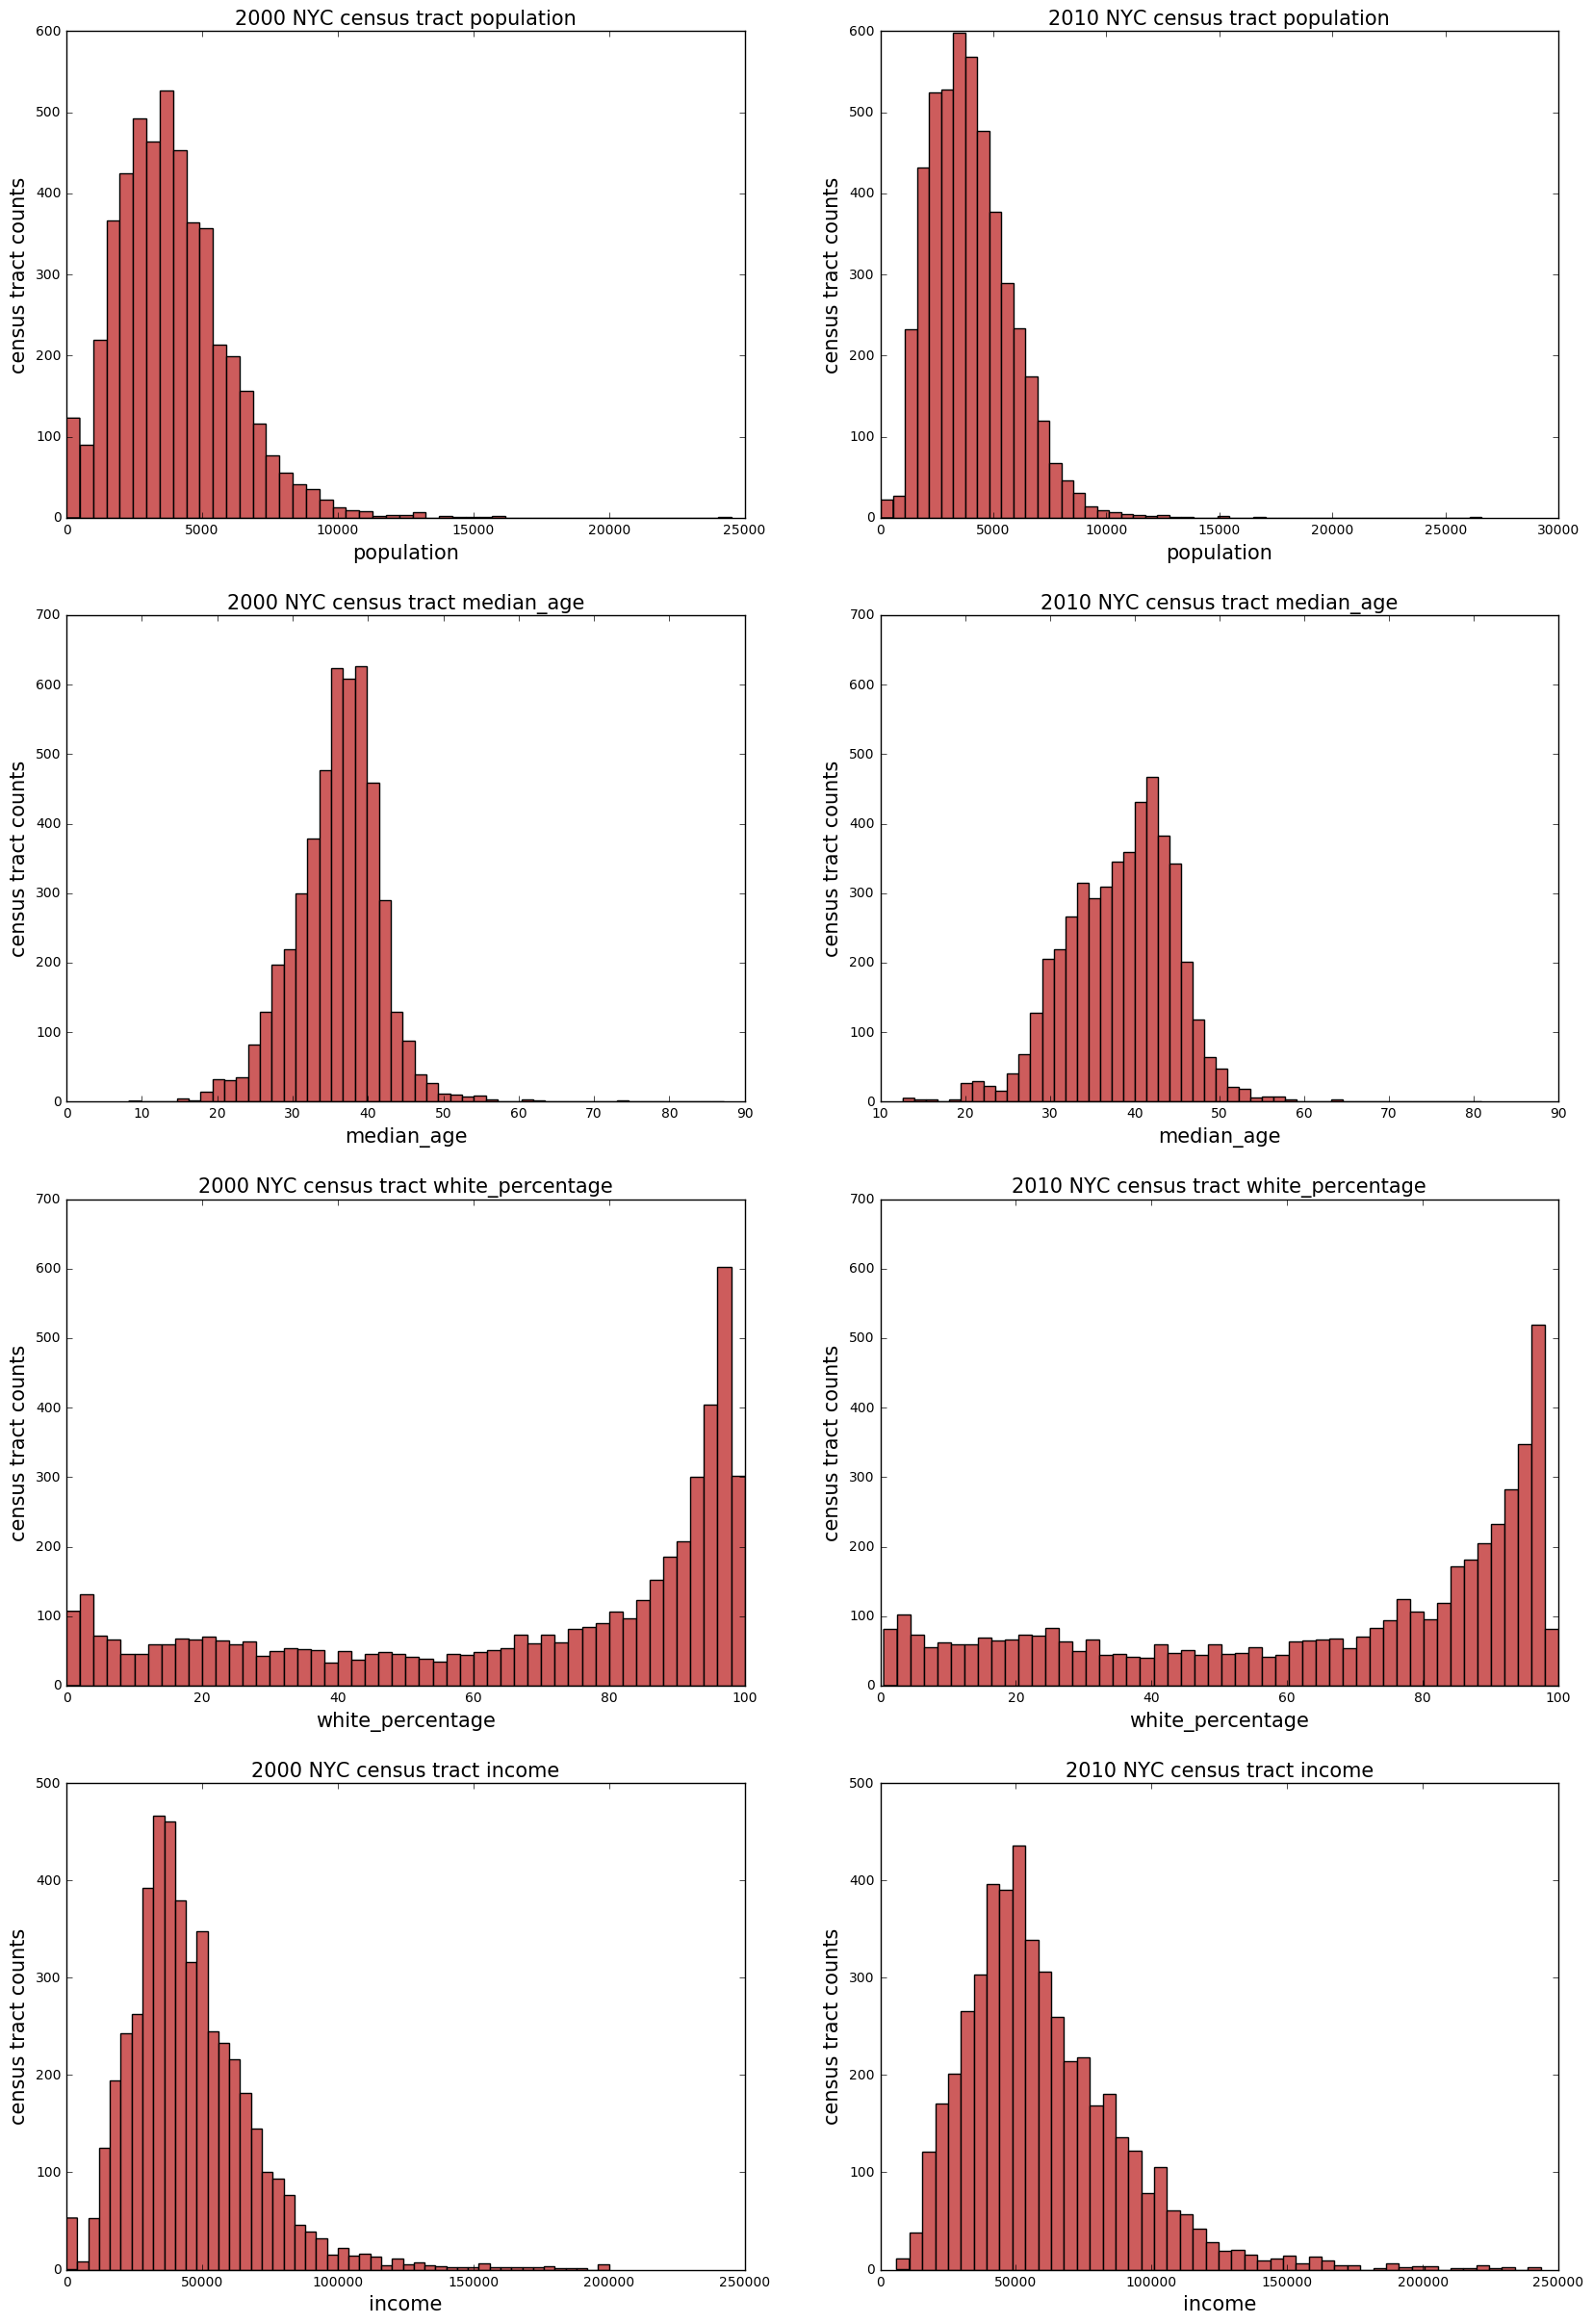

In [171]:
fig = plt.figure(figsize = (20,30))
k = 1
for i in range(1,5):
    
    if i == 1:
        cl = 'population'     
    elif i == 2 :
        cl = 'median_age'
    elif i == 3:
        cl = 'white_percentage'
    else:
        cl = 'income'
        
    ax1 = fig.add_subplot(4,2,k)
    plt.hist( census2000[cl] , 50 , color = 'indianred')     
    plt.xlabel('%s'%cl ,fontsize = 15)
    plt.ylabel('census tract counts',fontsize = 15 )    
    plt.title( '%s %s'%('2000 NYC census tract' , cl), fontsize = 15)    
   
    ax2 = fig.add_subplot(4,2,(k+1) ,sharey = ax1)
    plt.hist( census2010[cl] , 50 , color = 'indianred')     
    plt.xlabel('%s'%cl ,fontsize = 15)
    plt.ylabel('census tract counts',fontsize = 15 )    
    plt.title( '%s %s'%('2010 NYC census tract' , cl), fontsize = 15)  
    
    k += 2

#### caption: census tract 4 features histogram
#### Population: more census tracts; population are around 4000, in 2010 there are fewer census tracts with population above 10000. Population in each census tract is more even in 2010 than 2000.

#### Median_age: in 2000 the peak is between 30-40, and ten years later, in 2010 the peak is between 40-50. So the age structure is ageing. If the people stays the same, then the shape of age histogram will just move left 10 years long x-axis from 2000 to 2010. But the shape changes, which shows the people between 30-40 in 2000 are moving out in 2010,  and more young people between 30-40 in 2010 are moving in NYC.

#### White people percentage :census tracts with high percentage white people are decreasing

#### Income: peak of income increase , means generally people's income are increasing. Also the shape of data in 2000 in more concentrated around 40000 , and the shape in 2010 is more spread,which means standard deviation are larger in 2010, so gap between the poor and the rich are larger

## 7) Merge the census features data with shapefile. Display each of features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

In [47]:
query = '''
SELECT ct_2010 , boro_name , the_geom
FROM table_2010_census_tracts
'''

datastream = queryCartoDB(query, format='GeoJSON')
datageo  = json.loads(datastream.read())
ct = gpd.GeoDataFrame.from_features(datageo['features'])
ct.head()

boro_name ct_2010                                           geometry
0  Brooklyn  050804  (POLYGON ((-73.96140699999999 40.65217, -73.96...
1  Brooklyn  027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...
2     Bronx  009200  (POLYGON ((-73.847279 40.829315, -73.847320999...
3    Queens  099100  (POLYGON ((-73.791793 40.789352, -73.791563999...
4    Queens  000100  (POLYGON ((-73.949113 40.754524, -73.949144 40...

#### use census tract 2010 shapefile for both 2000 and 2010, possibly will cause some errors.
#### use county ID and census tract number to generate geo_id

In [50]:
countyID = {'Bronx':'005',
            'Manhattan':'061',
            'Staten Island':'085',
            'Brooklyn':'047',
            'Queens':'081'}

In [51]:
ct['allcodes'] = list(zip(ct.boro_name, ct.ct_2010))
ct['geo_id2']  = ct[['allcodes']].applymap(lambda x:
                                          ("36%03d%06d"%(int(countyID[x[0]]),
                                                         int(x[1]))))


In [52]:
ct = ct[['boro_name' , 'geo_id2' , 'geometry']]
ct.geo_id2  = pd.to_numeric(ct.geo_id2 , errors = 'coerce')
ct.head()

boro_name      geo_id2                                           geometry
0  Brooklyn  36047050804  (POLYGON ((-73.96140699999999 40.65217, -73.96...
1  Brooklyn  36047027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...
2     Bronx  36005009200  (POLYGON ((-73.847279 40.829315, -73.847320999...
3    Queens  36081099100  (POLYGON ((-73.791793 40.789352, -73.791563999...
4    Queens  36081000100  (POLYGON ((-73.949113 40.754524, -73.949144 40...

#### merge census tract shapefile with demography and income data

In [191]:
data_2000 = ct.merge(census2000, on = 'geo_id2' , how = 'inner')
data_2000.head()

boro_name      geo_id2                                           geometry  \
0  Brooklyn  36047027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
1     Bronx  36005009200  (POLYGON ((-73.847279 40.829315, -73.847320999...   
2    Queens  36081099100  (POLYGON ((-73.791793 40.789352, -73.791563999...   
3    Queens  36081000100  (POLYGON ((-73.949113 40.754524, -73.949144 40...   
4  Brooklyn  36047024100  (POLYGON ((-73.951465 40.689863, -73.955122 40...   

   population  median_age  white_percentage  income  
0        4171        33.9               1.5   30241  
1        4877        31.7              30.1   36589  
2        6659        47.1              87.7   62341  
3        1370        41.3              55.4   85898  
4        1564        36.2              10.4   10500

In [193]:
data_2010 = ct.merge(census2010, on = 'geo_id2', how = 'inner')
data_2010.head()

boro_name      geo_id2                                           geometry  \
0  Brooklyn  36047050804  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1  Brooklyn  36047027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
2     Bronx  36005009200  (POLYGON ((-73.847279 40.829315, -73.847320999...   
3    Queens  36081099100  (POLYGON ((-73.791793 40.789352, -73.791563999...   
4    Queens  36081000100  (POLYGON ((-73.949113 40.754524, -73.949144 40...   

   population  median_age  white_percentage    income  
0        6250        32.7              15.5   40188.0  
1        4180        35.6               9.1   52958.0  
2        5017        33.3              29.5   45625.0  
3        6507        51.1              85.5   84350.0  
4        4949        32.4              63.5  117750.0

#### as data_2010 and data_2000 are both geodataframe, cannot merge directly, so create d_10 as pandas dataframe, without geometry column, to merge with data_2010

In [194]:
d_10 = data_2010[['geo_id2' , 'population' , 'median_age' , "white_percentage" , 'income']]

In [195]:
census_diff = data_2000.merge(d_10, on = 'geo_id2' , how = 'inner')

In [196]:
census_diff['population'] = census_diff['population_y'] - census_diff['population_x']
census_diff['median_age'] = census_diff['median_age_y'] - census_diff['median_age_x']
white_diff = census_diff['white_percentage_y'] - census_diff['white_percentage_x']
census_diff['white_percentage'] = white_diff
census_diff['income'] = census_diff['income_y'] - census_diff['income_x']


In [197]:
census_diff = census_diff[['boro_name','geo_id2','geometry',
                           'population',"median_age","white_percentage",'income']]

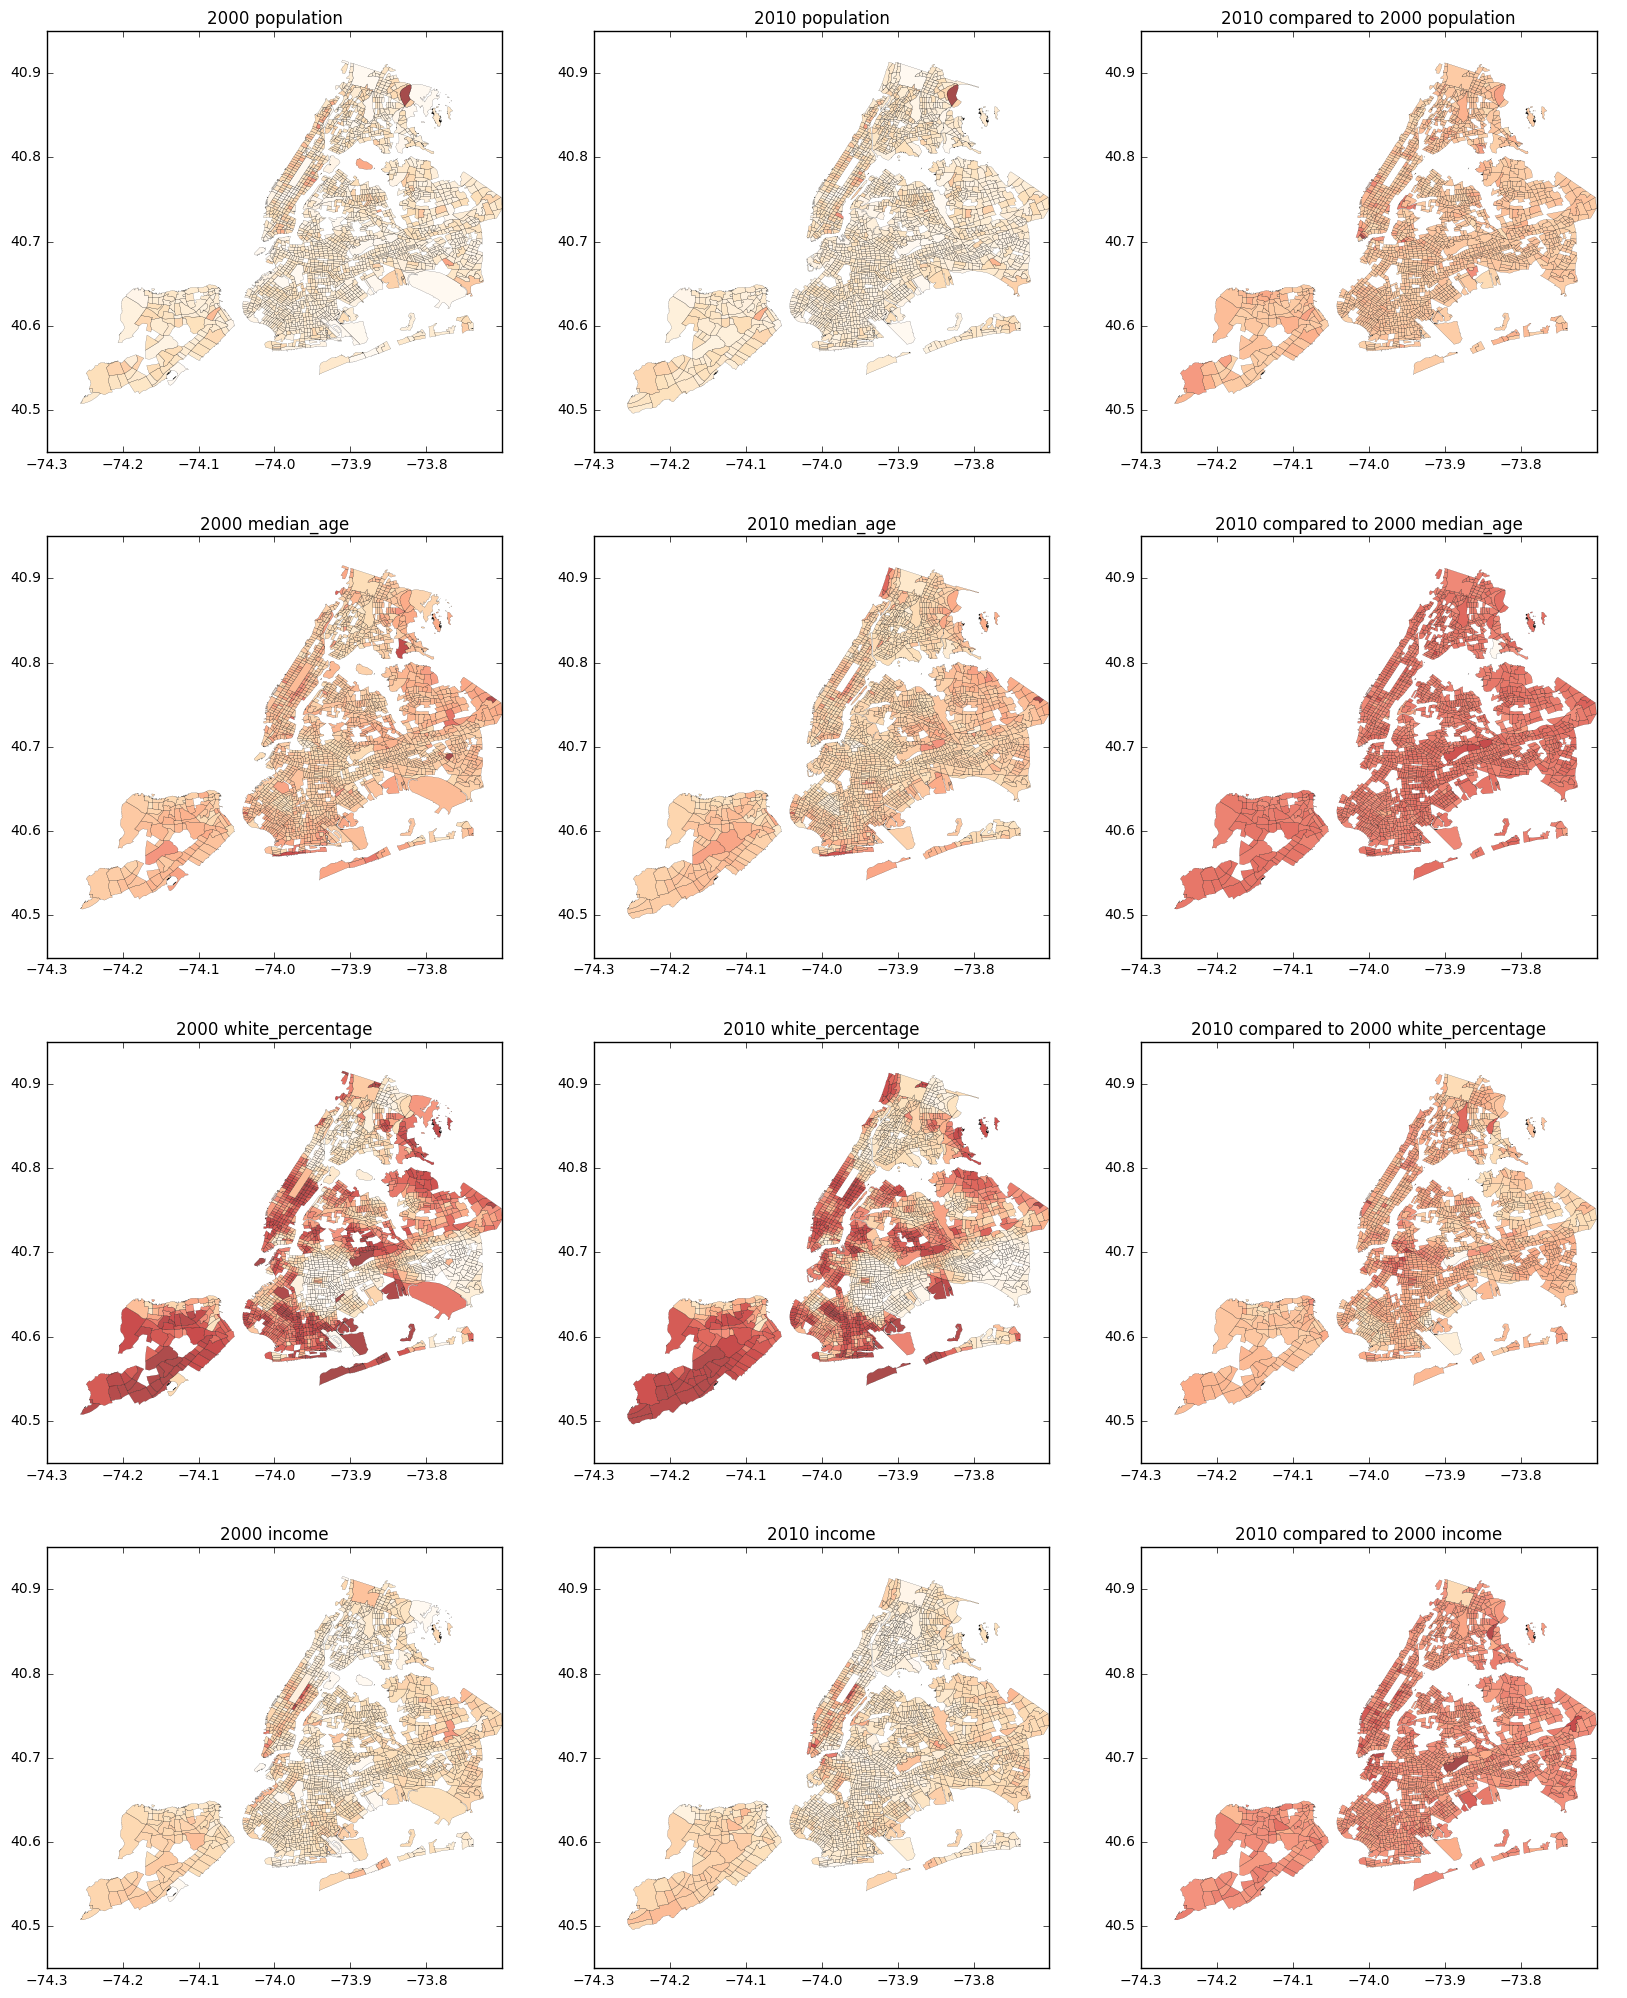

In [205]:
fig = plt.figure(figsize = (20,25) )
k = 1
for i in range(1,5):
    for j in range(1,4):
        ax = fig.add_subplot(4,3,k)
        if i == 1:
            cl = 'population'
        elif i ==2 :
            cl = 'median_age'
        elif i ==3 :
            cl = 'white_percentage'
        else:
            cl = 'income'
        
        if j == 1:
            df_ = data_2000
            t = '2000'
        elif j == 2 :
            df_ = data_2010
            t = '2010'
        else:
            df_ = census_diff
            t = '2010 compared to 2000'
        
        title_ = '%s %s'%(t , cl)
        df_.plot(column = cl , colormap = 'OrRd' , alpha = 0.7 , linewidth = 0.1, ax = ax)
        plt.title( title_)
        plt.xlim( -74.3, -73.7)
        plt.ylim( 40.45, 40.95)
        
        k += 1

#### Caption:12 plots above: First column is 2000, second column is 2010, third column is difference(value in 2010 subtract 2000 );  First row is population, second row is median age, third row is white people percentage, forth row is income. Combined with 6) plot, translation of plots as below:

#### Population : 
Why 2010& 2000 population plots are generally very light ? Because population are mostly concentrated around 4000, there are very few tract has very large population.  So the difference map makes more sense, we can see Manhattan has some tracts grows population most.

#### Median age : 
Why the difference map are so dark? Because there is a census tract has decrease median age greatly , so the others become really dark . So about median age, 2000 & 2010 age map make more sense.

#### White people percentage: 
2000 & 2010 white people percentage maps show clearly where is with higher proportion of white people. And difference map shows North Brooklyn has greatest increase of white people percentage.

#### Income:
2000 and 2010 income map shows downtown Manhattan and upper east Manhattan are highest income place, which agrees with common sense. Additionally, from  difference map, we can see somewhere in Queens increase income most.

In [225]:
print min(census_diff.income)
print max(census_diff.income)

-132310.0
104875.0


In [227]:
census_diff[census_diff.income == -132310 ]

boro_name      geo_id2  \
274  Manhattan  36061010200   

                                              geometry  population  \
274  (POLYGON ((-73.971243 40.760936, -73.971695999...         -39   

     median_age  white_percentage    income  
274        -1.1             -18.3 -132310.0

In [228]:
data_2000[data_2000.geo_id2 == 36061010200]

boro_name      geo_id2  \
288  Manhattan  36061010200   

                                              geometry  population  \
288  (POLYGON ((-73.971243 40.760936, -73.971695999...         269   

     median_age  white_percentage  income  
288        48.1              94.8  174119

In [230]:
data_2010[data_2010.geo_id2 == 36061010200]

boro_name      geo_id2  \
317  Manhattan  36061010200   

                                              geometry  population  \
317  (POLYGON ((-73.971243 40.760936, -73.971695999...         230   

     median_age  white_percentage   income  
317        47.0              76.5  41809.0

####  As income difference map is generally dark, let's have a look of the extremely low value, which makes the other census tract really dark. It's is 36061010200 in Manhattan, in 2000 it's income is 174199, while in 2010 it's income becomes 41809, decreasing enormously.

In [210]:
print min(census_diff.median_age)
print max(census_diff.median_age)

-46.0
22.4


In [211]:
census_diff[census_diff.median_age == -46.0]

boro_name      geo_id2  \
1504     Bronx  36005011000   

                                               geometry  population  \
1504  (POLYGON ((-73.83629999999999 40.828365, -73.8...        -246   

      median_age  white_percentage   income  
1504       -46.0             -17.1  32180.0

In [220]:
data_2000[data_2000.geo_id2 == 36005011000]

boro_name      geo_id2  \
1525     Bronx  36005011000   

                                               geometry  population  \
1525  (POLYGON ((-73.83629999999999 40.828365, -73.8...         397   

      median_age  white_percentage  income  
1525        69.3              63.5    9461

In [219]:
data_2010[data_2010.geo_id2 == 36005011000]

boro_name      geo_id2  \
1679     Bronx  36005011000   

                                               geometry  population  \
1679  (POLYGON ((-73.83629999999999 40.828365, -73.8...         151   

      median_age  white_percentage   income  
1679        23.3              46.4  41641.0

####  As median age difference map is generally dark, let's have a look of the extremely low value, which makes the other census tract really dark. It is 36005011000 ,  in Bronx, in 2000 it's median age is 69.3 , and in 2010 is 23.3 , which means the age decrease a lot! Also it's income increase a lot, at this place something happens during 10 years. 

## 8) Cluster the census tracts on these four features: population, median_age, white_percentage, income

In [236]:
data_2000 = data_2000.dropna()
data_2010 = data_2010.dropna()

In [238]:
n = 4
clusters = KMeans( n_clusters = n, random_state = 666 ).fit( data_2000.iloc[:,3:7] )
#cmap = plt.cm.plasma(np.linspace(0,1,n))
data_2000['label'] = clusters.labels_

In [239]:
data_2000.head()

boro_name      geo_id2                                           geometry  \
0  Brooklyn  36047027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
1     Bronx  36005009200  (POLYGON ((-73.847279 40.829315, -73.847320999...   
2    Queens  36081099100  (POLYGON ((-73.791793 40.789352, -73.791563999...   
3    Queens  36081000100  (POLYGON ((-73.949113 40.754524, -73.949144 40...   
4  Brooklyn  36047024100  (POLYGON ((-73.951465 40.689863, -73.955122 40...   

   population  median_age  white_percentage  income  label  
0        4171        33.9               1.5   30241      2  
1        4877        31.7              30.1   36589      0  
2        6659        47.1              87.7   62341      1  
3        1370        41.3              55.4   85898      1  
4        1564        36.2              10.4   10500      2

#### As start points effect KMeans Clustering result, so I pass the centroids of 2000 KMeans clustering to 2010 clustering as starting points

In [240]:
center_2000 = clusters.cluster_centers_

In [244]:
n = 4
clusters = KMeans( n_clusters = n, random_state = 666,
                  init = center_2000).fit(data_2010.iloc[:,3:7] )
#cmap = plt.cm.plasma(np.linspace(0,1,n))
data_2010['label'] = clusters.labels_

In [245]:
data_2010.head()

boro_name      geo_id2                                           geometry  \
0  Brooklyn  36047050804  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1  Brooklyn  36047027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
2     Bronx  36005009200  (POLYGON ((-73.847279 40.829315, -73.847320999...   
3    Queens  36081099100  (POLYGON ((-73.791793 40.789352, -73.791563999...   
4    Queens  36081000100  (POLYGON ((-73.949113 40.754524, -73.949144 40...   

   population  median_age  white_percentage    income  label  
0        6250        32.7              15.5   40188.0      2  
1        4180        35.6               9.1   52958.0      0  
2        5017        33.3              29.5   45625.0      0  
3        6507        51.1              85.5   84350.0      1  
4        4949        32.4              63.5  117750.0      3

## 9) Show two choropleths of the clusters in 2010, 2000. And one more choropleth of the cluster changes.

#### Choropleth above color has sequential meaning. Here cluster numbers doesn't mean sequence, so use qualitative colormap is better 

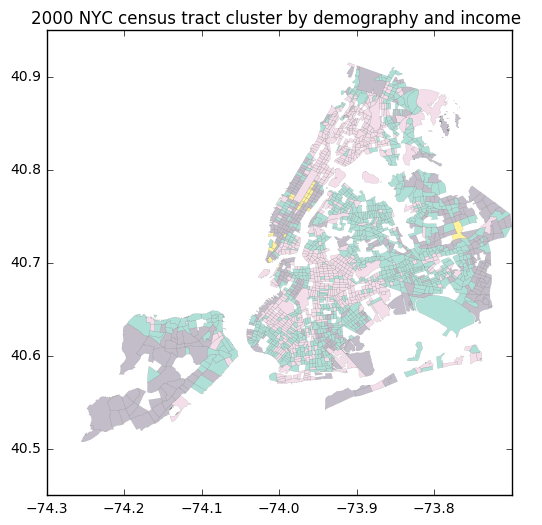

In [246]:
choropleth(df = data_2000 , column = 'label' , cm = 'Set3',
          title = '2000 NYC census tract cluster by demography and income ',
          c_bar = False)

#### caption: different color show 2000 NYC census tract in different clusters based on 4 features: population , median age, income ,white percentag.

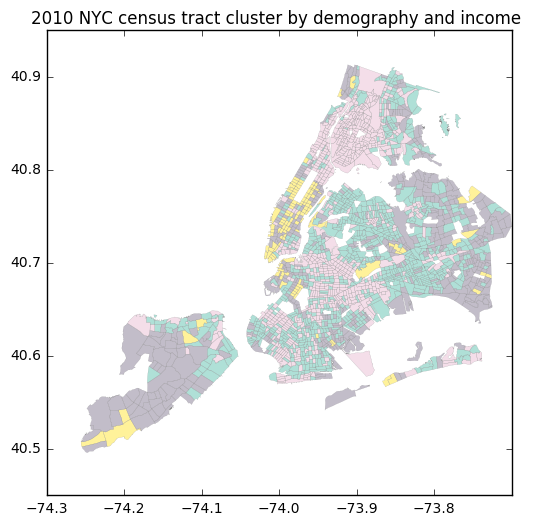

In [247]:
choropleth(df = data_2010 , column = 'label' , cm = 'Set3',
          title = '2010 NYC census tract cluster by demography and income ',
          c_bar = False)

#### caption: different color show 2010 NYC census tract in different clusters based on 4 features: population , median age, income ,white percentag.

#### to find out which census tract changes clustering

In [374]:
label00 = data_2000[['geo_id2','geometry','label']]
label10 = data_2010[['geo_id2','label']]
label = label00.merge(label10, on = 'geo_id2', how = 'inner')


In [375]:
for i in range(len(label)):
    if label.label_x[i] != label.label_y[i]:
        label.loc[i,'label_diff'] = 1
    else:
        label.loc[i,'label_diff'] = 0

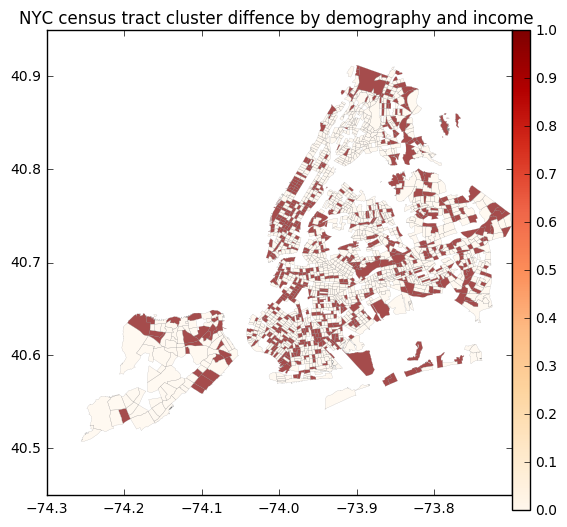

In [251]:
choropleth(df = label , column = 'label_diff' ,
          title = 'NYC census tract cluster diffence by demography and income ')

#### Caption: The red census tracts change clustering groups. So these areas have big change in their features: population, income, white people percentage and median age. And North Queens , Bronx, and Staten island seem to be more stable between 2000 and 2010. Manhattan and Brooklyn changes more.

## 10) Aggregate the census four features at the zipcode level and merge with the zipcode polygon data

#### If a zipcode area contains centroid of a census tract, then the census tract belongs to the zipcode

In [252]:
data_2000.crs = from_epsg(4326)
data_2010.crs = from_epsg(4326)

In [253]:
data_2000['centroid'] = data_2000.geometry.centroid

In [255]:
data_2000 = data_2000.reset_index(drop = True)

In [256]:
data_2000.head()

boro_name      geo_id2                                           geometry  \
0  Brooklyn  36047027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
1     Bronx  36005009200  (POLYGON ((-73.847279 40.829315, -73.847320999...   
2    Queens  36081099100  (POLYGON ((-73.791793 40.789352, -73.791563999...   
3    Queens  36081000100  (POLYGON ((-73.949113 40.754524, -73.949144 40...   
4  Brooklyn  36047024100  (POLYGON ((-73.951465 40.689863, -73.955122 40...   

   population  median_age  white_percentage  income  label  \
0        4171        33.9               1.5   30241      2   
1        4877        31.7              30.1   36589      0   
2        6659        47.1              87.7   62341      1   
3        1370        41.3              55.4   85898      1   
4        1564        36.2              10.4   10500      2   

                                       centroid  
0  POINT (-73.93817849385184 40.68389708695573)  
1  POINT (-73.85210982299243 40.83235742729679)  
2  POINT (-73.80002157849106 40.79030242380239)  
3  POINT (-73.95065299870262 40.74321286156224)  
4  POINT (-73.95380379679214 40.69222179804105)

#### in order to reduce computation times, I relate zipcode with borough. As each census tract has borough information, then census centoid could be compared with zipcode in the same borough.
zipcode info as below:
https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm

In [257]:
borough = {'Bronx' : [10453, 10457, 10460, 10458, 10467, 10468, 10451, 10452, 10456,
                      10454, 10455, 10459, 10474, 10463, 10471, 10466, 10469, 10470,
                      10475, 10461, 10462,10464, 10465, 10472, 10473],
           "Brooklyn" : [11212, 11213, 11216, 11233, 11238, 11209, 11214, 11228,
                         11204, 11218, 11219, 11230, 11234, 11236, 11239, 11223,
                         11224, 11229, 11235, 11201, 11205, 11215, 11217, 11231,
                         11203, 11210, 11225, 11226, 11207, 11208, 11211, 11222,
                         11220, 11232, 11206, 11221, 11237],
           "Manhattan" : [10026, 10027, 10030, 10037, 10039, 10001, 10011, 10018,
                          10019, 10020, 10036, 10029, 10035, 10010, 10016, 10017,
                          10022, 10012, 10013, 10014, 10004, 10005, 10006, 10007,
                          10038, 10280, 10002, 10003, 10009, 10021, 10028, 10044,
                          10065, 10075, 10128, 10023, 10024, 10025, 10031, 10032,
                          10033, 10034, 10040],
           "Queens" : [11361, 11362, 11363, 11364, 11354, 11355, 11356, 11357,
                       11358, 11359, 11360, 11365, 11366, 11367, 11412, 11423,
                       11432, 11433, 11434, 11435, 11436, 11101, 11102, 11103,
                       11104, 11105, 11106, 11374, 11375, 11379, 11385, 11691,
                       11692, 11693, 11694, 11695, 11697, 11004, 11005, 11411,
                       11413, 11422, 11426, 11427, 11428, 11429, 11414, 11415, 
                       11416, 11417, 11418, 11419, 11420, 11421, 11368, 11369,
                       11370, 11372, 11373, 11377, 11378],
           "Staten Island" : [10302, 10303, 10310, 10306, 10307, 10308, 10309,
                              10312, 10301, 10304, 10305, 10314]}

In [258]:
# add boro name column into zipcode shapefile
for i,zi in enumerate(zipcode_shape['zip']):
    if zi in borough['Bronx']:
        zipcode_shape.ix[i , 'boro_name'] = 'Bronx'
    elif zi in borough['Brooklyn']:
        zipcode_shape.ix[i ,'boro_name'] = 'Brooklyn'
    elif zi in borough['Manhattan']:
        zipcode_shape.ix[i ,'boro_name'] = 'Manhattan'
    elif zi in borough['Queens']:
        zipcode_shape.ix[i ,'boro_name'] = 'Queens'
    elif zi in borough['Staten Island']:
        zipcode_shape.ix[i ,'boro_name'] = 'Staten Island'
    else:
        zipcode_shape.ix[i ,'boro_name'] = 0

In [259]:
## divide zipcode data into 5 borough and 1 un-known 

manhattan = zipcode_shape[zipcode_shape.boro_name == 'Manhattan' ].reset_index(drop = True)
brooklyn = zipcode_shape[zipcode_shape.boro_name == 'Brooklyn' ].reset_index(drop = True)
queens = zipcode_shape[zipcode_shape.boro_name == 'Queens' ].reset_index(drop = True)
staten = zipcode_shape[zipcode_shape.boro_name == 'Staten Island' ].reset_index(drop = True)
bronx = zipcode_shape[zipcode_shape.boro_name == 'Bronx' ].reset_index(drop = True)
no_boro = zipcode_shape[zipcode_shape.boro_name == 0 ].reset_index(drop = True)

In [260]:
## divide census data into 5 dataframes

ct00manhattan = data_2000[data_2000.boro_name == 'Manhattan' ].reset_index(drop = True)
ct00brooklyn = data_2000[data_2000.boro_name == 'Brooklyn' ].reset_index(drop = True)
ct00queens = data_2000[data_2000.boro_name == 'Queens' ].reset_index(drop = True)
ct00staten = data_2000[data_2000.boro_name == 'Staten Island' ].reset_index(drop = True)
ct00bronx = data_2000[data_2000.boro_name == 'Bronx' ].reset_index(drop = True)

#### mapping census tract into zipcode in each borough, and then merge 5 borough's census tracts together

In [261]:
# i is each row in data_2000
# j is each row in zipcode shapefile
def findzip(df1 , df2):
    """find each census track belongs to which zip code
    Variables:
    df1 : census tract's dataframe 
    df2 : zipcode's dataframe (borough data)
    """
    for i in range(len(df1)):
        for j in range( len( df2) ):
            if df2.ix[j,'geometry'].contains( df1.centroid[i] ):
                df1.ix[i , 'zip'] = df2.ix[j , 'zip']
                break
            elif no_boro.ix[j,'geometry'].contains( df1.centroid[i] ):
                df1.ix[i , 'zip'] = no_boro.ix[j , 'zip']
                break

In [262]:
findzip(ct00staten , staten)

In [263]:
findzip(ct00manhattan , manhattan)

In [264]:
findzip(ct00bronx , bronx)

In [265]:
findzip(ct00queens , queens)

In [266]:
findzip(ct00brooklyn , brooklyn)

In [267]:
sublist = [ct00staten , ct00manhattan , ct00queens , ct00brooklyn , ct00bronx]
data_2000 = pd.concat( sublist ).reset_index(drop = True)

In [319]:
data_2000.head(3)

boro_name      geo_id2  \
0  Staten Island  36085029102   
1  Staten Island  36085015603   
2  Staten Island  36085017010   

                                            geometry  population  median_age  \
0  (POLYGON ((-74.19556 40.635024, -74.1924889999...        2331        35.1   
1  (POLYGON ((-74.135857 40.546452, -74.136412000...        4392        37.1   
2  (POLYGON ((-74.187573 40.550148, -74.188076 40...        9278        34.2   

   white_percentage  income  label  \
0              87.1   57708      1   
1              94.6   62534      1   
2              89.5   67774      1   

                                       centroid      zip  
0  POINT (-74.19026228117856 40.60936784860323)  10314.0  
1  POINT (-74.14758783172729 40.53793422599656)  10308.0  
2   POINT (-74.1960466325863 40.55109917069179)  10312.0

#### After getting zipcode in 2000 census tract, then the same census tract in 2010 dataframe is in the same zipcode. So in order to minimize for loop in findzip function, I merge 2000 and 2010 dataframe on "geo_id2". And those new census track in 2010 dataframe ( only 242 ) should run findzip function again.

In [269]:
d0 = data_2000[['geo_id2' , 'zip']]

In [270]:
data_2010 = data_2010.merge(d0 , on = 'geo_id2' , how = 'left' )

In [271]:
data_2010.head(3)

boro_name      geo_id2                                           geometry  \
0  Brooklyn  36047050804  (POLYGON ((-73.96140699999999 40.65217, -73.96...   
1  Brooklyn  36047027500  (POLYGON ((-73.935008 40.682764, -73.937932 40...   
2     Bronx  36005009200  (POLYGON ((-73.847279 40.829315, -73.847320999...   

   population  median_age  white_percentage   income  label      zip  
0        6250        32.7              15.5  40188.0      2      NaN  
1        4180        35.6               9.1  52958.0      0  11233.0  
2        5017        33.3              29.5  45625.0      0  10462.0

In [272]:
data_2010['zip'] = np.nan_to_num( data_2010['zip'] )

In [273]:
data_2010_0 = data_2010 [data_2010['zip'] == 0].reset_index( drop = True)
data_2010_1 = data_2010 [data_2010['zip'] != 0].reset_index( drop = True)

In [ ]:
zipcode_shape.head()

In [ ]:
data_2010_0.head(2)

#### function findzip compare with specific borough zipcode dataframe and unknown borough zipcode
#### function findzip2 compare with the whole zipcode dataframe

In [274]:
# i is each row in data_2000
# j is each row in zipcode shapefile
def findzip2(df1 , df2):
    """find each census track belongs to which zip code
    Variables:
    df1 : census tract's dataframe 
    df2 : zipcode's dataframe
    """
    for i in range(len(df1)):
        for j in range( len( df2) ):
            if df2.ix[j,'geometry'].contains( df1.centroid[i] ):
                df1.ix[i , 'zip'] = df2.ix[j , 'zip']
                break

In [275]:
findzip2(data_2010_0 , zipcode_shape)

In [276]:
data_2010 = pd.concat( [data_2010_0 , data_2010_1] ).reset_index( drop = True ) 

#### check if there is any census tract cannot find its zipcode area

In [277]:
data_2010[data_2010['zip'] == 0]

boro_name      geo_id2                                           geometry  \
17      Bronx  36005051600  (POLYGON ((-73.78833299999999 40.834667, -73.7...   
35      Bronx  36005011800  (POLYGON ((-73.797381 40.815764, -73.797441000...   
211  Brooklyn  36047069800  (POLYGON ((-73.911682 40.616852, -73.911445 40...   

     population  median_age  white_percentage   income  label  zip  
17         4362        47.3              85.4  64701.0      0  0.0  
35         5089        32.4              86.8  74607.0      1  0.0  
211        1277        41.9              87.2  67955.0      1  0.0

#### Look up in the website: 
https://www.huduser.gov/portal/datasets/usps_crosswalk.html
#### use data 2010 Quarter 1st, look those three census tract, to find out their zipcode manually

In [278]:
data_2010.loc[17 , 'zip'] = 10464
data_2010.loc[35 , 'zip'] = 10465
data_2010.loc[211 , 'zip'] = 11234

#### I double check those zipcode at google map. All these three zipcodes has complicated water border. 
#### The reason the census tract is not in zipcode polygon probably is: the census tract shape is concave polygon, the centroid of it is in water, which is out of its zipcode contour.

In [463]:
zip_2000 = data_2000[['population' ,
                       'median_age' ,
                       'white_percentage' ,
                       'income','zip']].groupby(data_2000['zip']).mean()

In [464]:
zip_2010= data_2010[['population',
                     'median_age',
                     'white_percentage',
                     'income','zip']].groupby(data_2010['zip']).mean()

In [466]:
zip_2000 = business.merge(zip_2000, on = 'zip' , how = 'inner')
zip_2000 = zip_2000.set_index(zip_2000['zip'])

zip_2010 = business.merge( zip_2010, on = 'zip' , how = 'inner')
zip_2010 = zip_2010.set_index(zip_2010['zip'])


In [482]:
zip_2000 = zip_2000.dropna()
zip_2010 = zip_2010.dropna()

In [483]:
zip_2010.head(3)

AREA    zip                                           geometry  \
zip                                                                             
11436  2.269930e+07  11436  POLYGON ((-73.80584847647394 40.68290932644246...   
11213  2.963100e+07  11213  POLYGON ((-73.93739763139813 40.67972958925082...   
11212  4.197210e+07  11212  POLYGON ((-73.90294132545438 40.67083977590006...   

        2000   2010  2000_density  2010_density  difference   population  \
zip                                                                        
11436   65.0   98.0     -5.543099     -5.364786    1.453790  1993.300000   
11213  477.0  675.0     -4.793228     -4.642443    6.682190  3762.705882   
11212  520.0  699.0     -4.906957     -4.778484    4.264737  4264.315789   

       median_age  white_percentage        income  
zip                                                
11436   35.080000          3.640000  62520.000000  
11213   32.047059         20.005882  36167.529412  
11212   31.694737          4.600000  28668.210526

## 11)  a.  plot  Census tract aggreagated at zipcode level by 5 features (population , income, median age, white people percentage )

In [484]:
z_10 = zip_2010[['zip' , 'population' , 'median_age' ,
                 "white_percentage" , 'income']]

In [485]:
zip_diff = zip_2000.merge(z_10, on = 'zip' , how = 'inner')

In [486]:
zip_diff.head(2)

AREA    zip                                           geometry  \
0  2.269930e+07  11436  POLYGON ((-73.80584847647394 40.68290932644246...   
1  2.963100e+07  11213  POLYGON ((-73.93739763139813 40.67972958925082...   

    2000   2010  2000_density  2010_density  difference  population_x  \
0   65.0   98.0     -5.543099     -5.364786     1.45379     2061.7000   
1  477.0  675.0     -4.793228     -4.642443     6.68219     3965.8125   

   median_age_x  white_percentage_x    income_x  population_y  median_age_y  \
0         33.25             1.63000  40976.6000   1993.300000     35.080000   
1         29.60            14.36875  26933.4375   3762.705882     32.047059   

   white_percentage_y      income_y  
0            3.640000  62520.000000  
1           20.005882  36167.529412

In [487]:
zip_diff['population'] = zip_diff['population_y'] - zip_diff['population_x']
zip_diff['median_age'] = zip_diff['median_age_y'] - zip_diff['median_age_x']
white_diff = zip_diff['white_percentage_y'] - zip_diff['white_percentage_x']
zip_diff['white_percentage'] = white_diff
zip_diff['income'] = zip_diff['income_y'] - zip_diff['income_x']


In [488]:
zip_diff = zip_diff[['zip','geometry','difference','population',
                     "median_age","white_percentage",'income']]

In [489]:
zip_diff = zip_diff.rename( columns = {'difference' : 'business'})
zip_2000 = zip_2000.rename( columns = {'2000_density' : 'business'})
zip_2010 = zip_2010.rename( columns = {'2010_density' : 'business'})

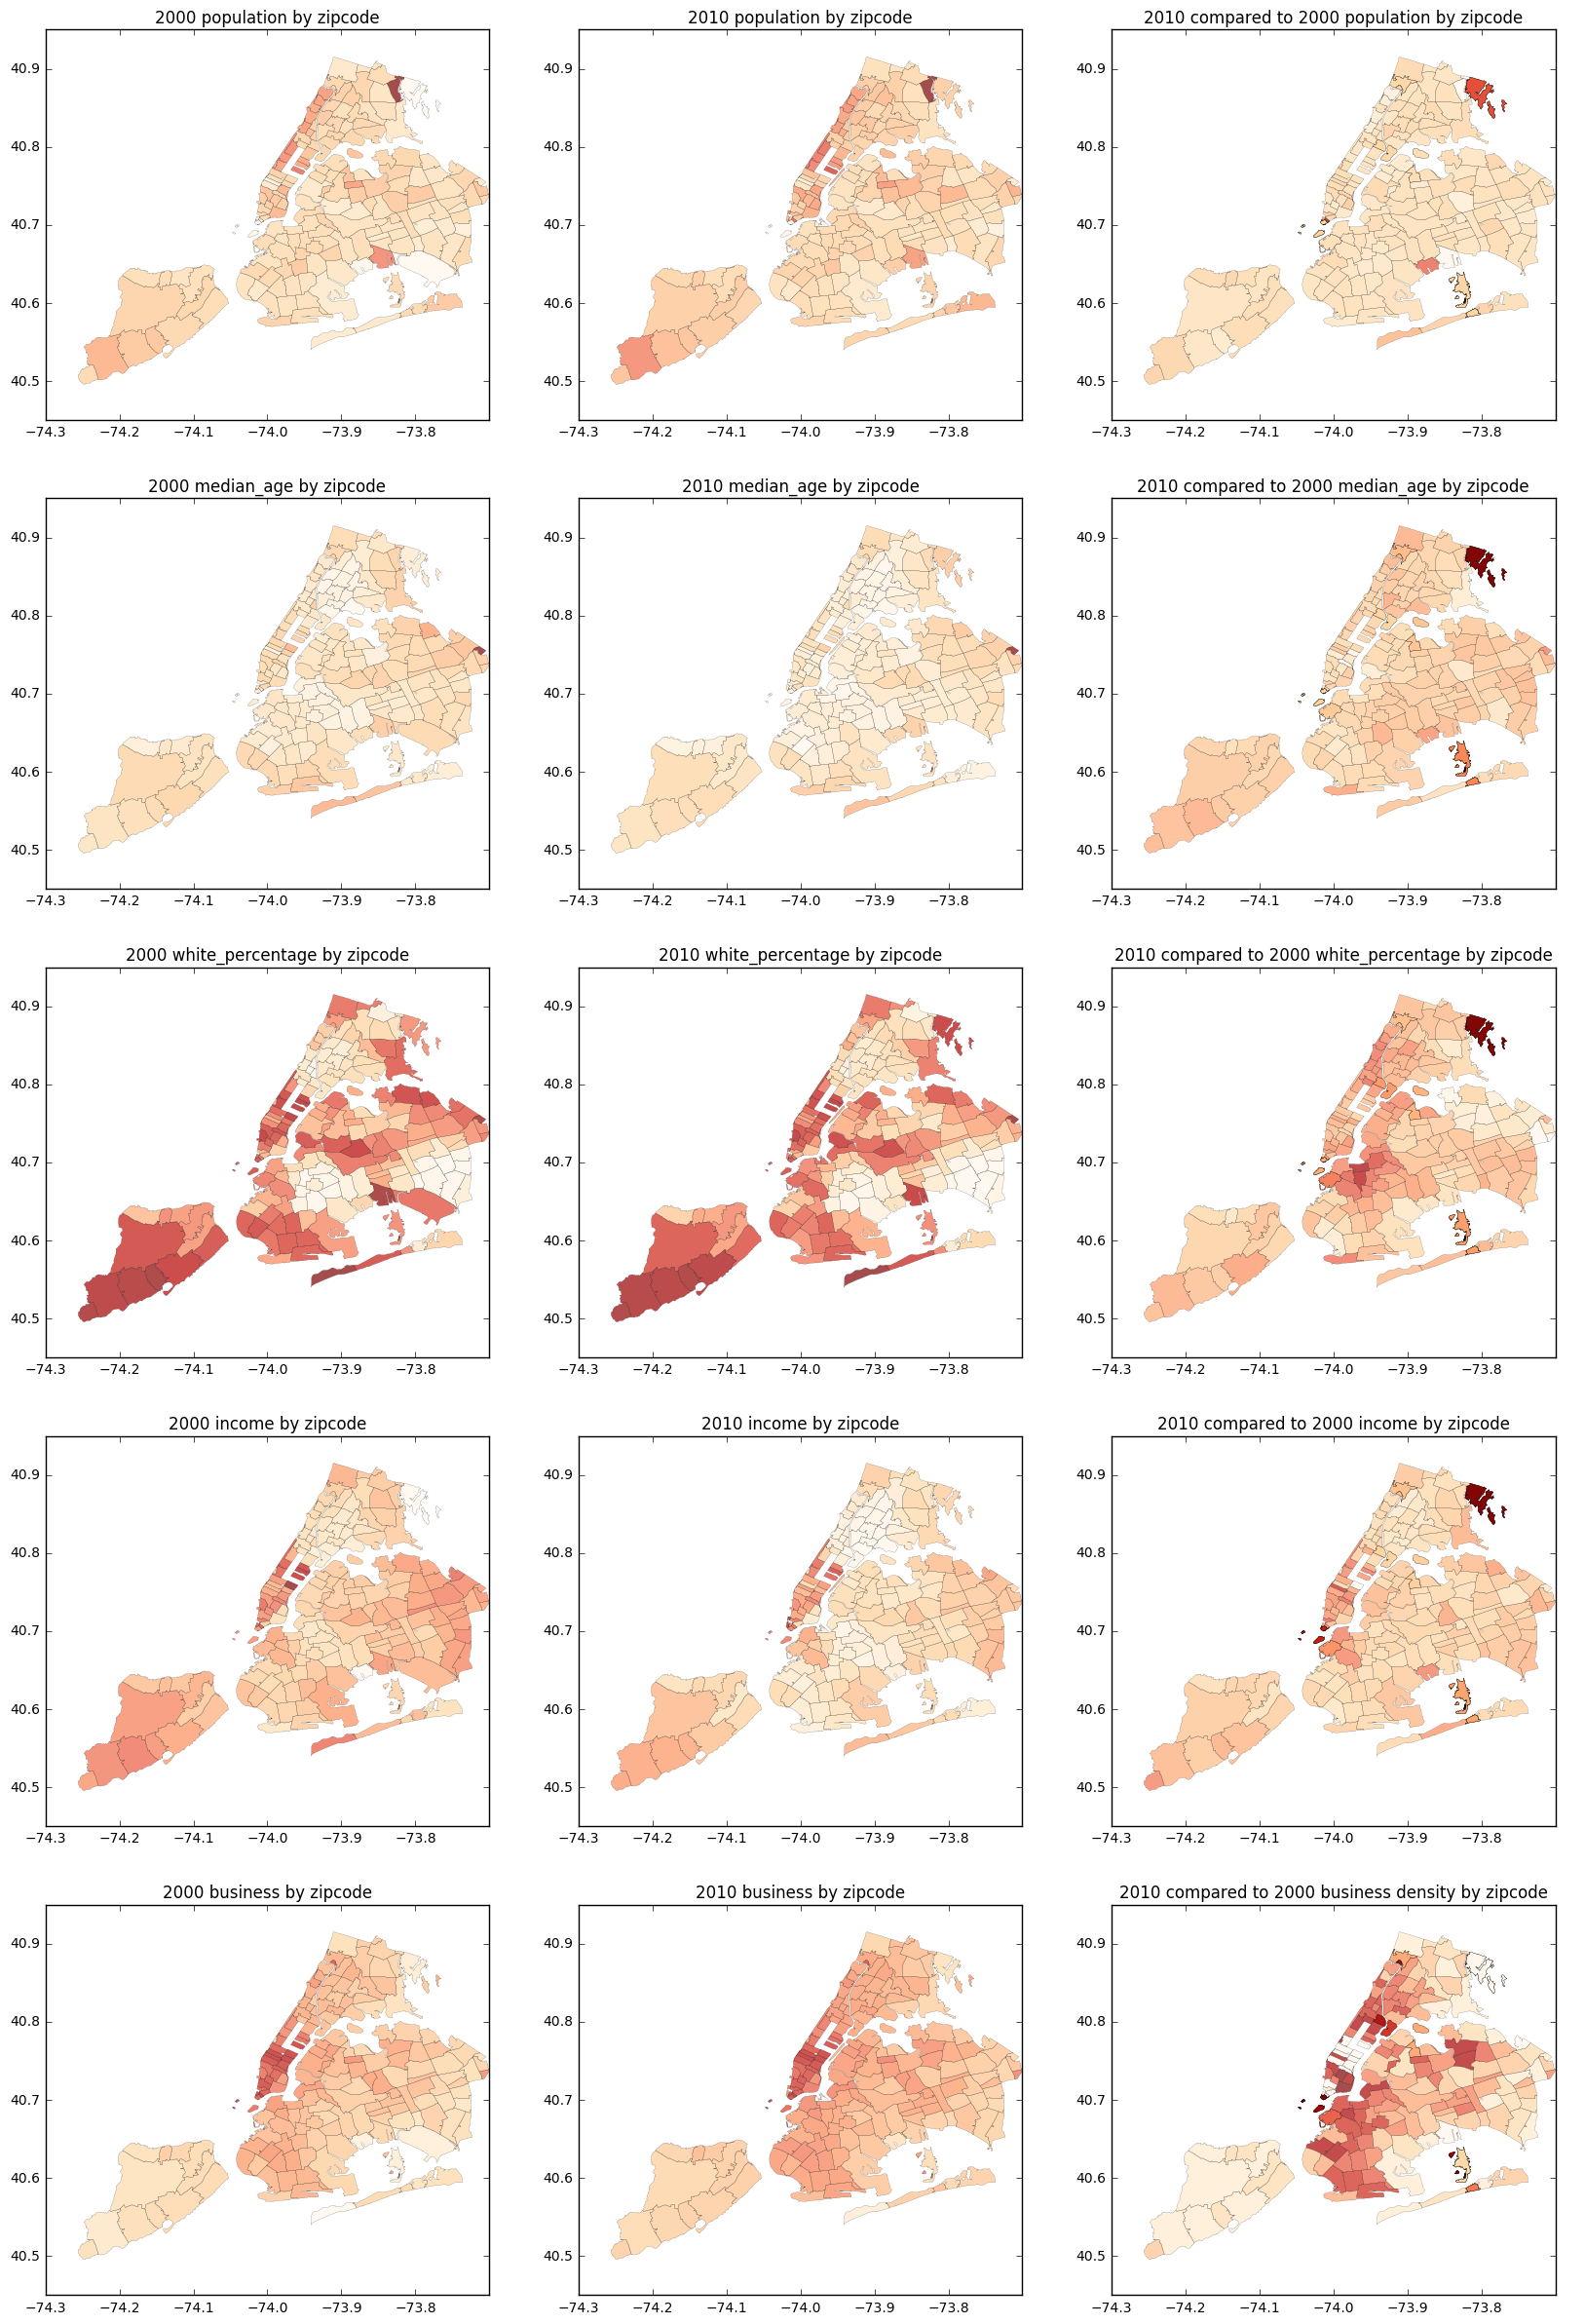

In [431]:
fig = plt.figure(figsize = (20,30) )
k = 1
for i in range(1,6):
    for j in range(1,4):
        ax = fig.add_subplot(5,3,k)
        
        if k ==15:
            lag10 = ps.Quantiles(zip_diff['business'], k=10)
            zip_diff.assign(cl = lag10.yb).plot(column = 'cl',
                                                categorical = True,
                                                k = 10, 
                                                cmap = 'OrRd',
                                                linewidth = 0.1,
                                                ax = ax,
                                                alpha = 0.7,
                                                legend = False)
            plt.xlim( -74.3, -73.7)
            plt.ylim( 40.45, 40.95)
            plt.title("2010 compared to 2000 business density by zipcode")
            break
        
        if i == 1:
            cl = 'population'
        elif i ==2 :
            cl = 'median_age'
        elif i ==3 :
            cl = 'white_percentage'
        elif i == 4:
            cl = 'income'
        else:
            cl = 'business'
        
        if j == 1:
            df_ = zip_2000
            t = '2000'
        elif j == 2 :
            df_ = zip_2010
            t = '2010'
        else:
            df_ = zip_diff
            t = '2010 compared to 2000'
        
        title_ = '%s %s by zipcode'%(t , cl)
        df_.plot(column = cl , colormap = 'OrRd' , alpha = 0.7 , linewidth = 0.1, ax = ax)
        plt.title( title_)
        plt.xlim( -74.3, -73.7)
        plt.ylim( 40.45, 40.95)
        
        k += 1
        
       

#### caption：After aggregating census tract by zipcode level, the pattern are more clearly  than cenus tract map. Detailed explanation as below.

#### Population : 
In 2000 and 2010 population maps, Manhattan especially west side has more population. But in difference map, one zipcode in Bronx grows most. Probably because that zopcode difference is so large, makes other zipcodes seem to be quite similar.
#### Median age:
In 2000 and 2010 median age maps, Brooklyn and south Bronx is lighter, means  people there are younger. And  in difference map, Manhattan, middle Brooklyn and Queens near Manhattan are light, so those places are getting younger.

#### White people percentage: 
In 2000 and 2010 maps, it's very clear Staten Island, Manhattan, West Brooklyn, North Queens have higher white people percentage. And from difference map, we can see one zipcode in Bronx, and north Brooklyn white people takes more proportion

#### Income: 
In income maps of 2000 and 2010, Manhattan, Staten Island and east Queens are richer. But in 2000, Staten Island and east Queens look similar, but in 2010 it seems that Staten Island are richer than East Queens, which is confirmed by difference map as well. From difference map we can see Manhattan is not only the richest, but also income grows most. And north Brooklyn grows a lot and income is high as well.

#### Business density:
In 2000 map, business are highly concentrated in Manhattan, the other places are far behind Manhattan. In 2010, businesses are still concentrated in Manhattan, but the gap between other places and Manhattan is narrowed. In difference map, I don't use business density difference directly to plot. Becaue the color are too even.So I divided business density difference into 10 intervals. Then color them according to which interval they are in. Then we can see in Midtown Manhattan, businesses almost don't grow. But in Brooklyn grows greatly between 10 years. Also south Bronx and some zipcodes in Queens grow a lot as well.

## 11) b. Cluster zipcode(aggreagated Census tract)  by 5 features (population , income, median age, white people percentage , business density)

In [490]:
zip_2000 = zip_2000[['zip','geometry','business',
                   'population','median_age',
                   'white_percentage','income']]

In [491]:
zip_2010 = zip_2010[['zip','geometry','business',
                   'population','median_age',
                   'white_percentage','income']]

In [492]:
n = 4
df = zip_2000[['business','population',
               'median_age','white_percentage','income']]
clusters = KMeans( n_clusters = n,
                  random_state = 666).fit(df)
zip_2000['label'] = clusters.labels_

In [493]:
zip_2000.head(3)

zip                                           geometry  business  \
zip                                                                         
11436  11436  POLYGON ((-73.80584847647394 40.68290932644246... -5.543099   
11213  11213  POLYGON ((-73.93739763139813 40.67972958925082... -4.793228   
11212  11212  POLYGON ((-73.90294132545438 40.67083977590006... -4.906957   

        population  median_age  white_percentage        income  label  
zip                                                                    
11436  2061.700000   33.250000          1.630000  40976.600000      2  
11213  3965.812500   29.600000         14.368750  26933.437500      0  
11212  4426.388889   28.427778          3.683333  22683.777778      0

In [494]:
center_zip = clusters.cluster_centers_

In [495]:
n = 4
df = zip_2010[['business','population','median_age','white_percentage','income']]
clusters = KMeans( n_clusters = n,
                  random_state = 666,
                 init = center_zip).fit(df)
zip_2010['label'] = clusters.labels_

In [496]:
zip_2010.head(3)

zip                                           geometry  business  \
zip                                                                         
11436  11436  POLYGON ((-73.80584847647394 40.68290932644246... -5.364786   
11213  11213  POLYGON ((-73.93739763139813 40.67972958925082... -4.642443   
11212  11212  POLYGON ((-73.90294132545438 40.67083977590006... -4.778484   

        population  median_age  white_percentage        income  label  
zip                                                                    
11436  1993.300000   35.080000          3.640000  62520.000000      2  
11213  3762.705882   32.047059         20.005882  36167.529412      0  
11212  4264.315789   31.694737          4.600000  28668.210526      0

## 11) c. Show zipcode clusters in Choropleth for 2000 and 2010 separately. And show cluster change in choropleth as well.

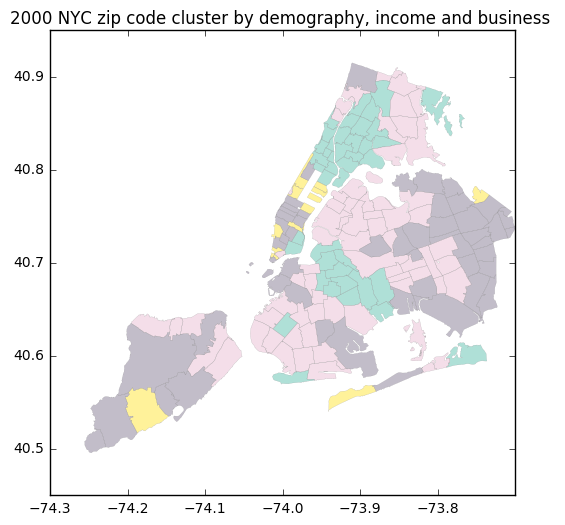

In [367]:
choropleth(df = zip_2000 , column = 'label' , cm = 'Set3',
           title = '2000 NYC zip code cluster by demography, income and business ',
           c_bar = False)

#### caption: different color show 2000 NYC zipcode in different clusters based on 5 features: population , median age, income ,white percentage, business.

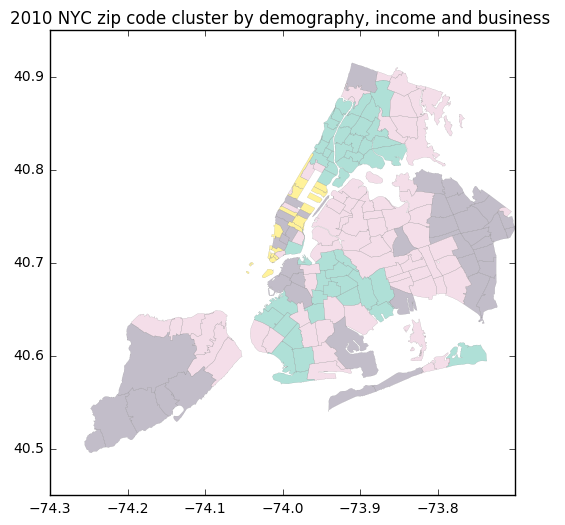

In [368]:
choropleth(df = zip_2010 , column = 'label' , cm = 'Set3',
           title = '2010 NYC zip code cluster by demography, income and business ',
           c_bar = False)

#### caption: different color show 2010 NYC zipcode in different clusters based on 5 features: population , median age, income ,white percentage, business.

## 12) find change clusters zipcode and find their features change

In [458]:
def cluser_change(df1, df2 , cl):
    '''
    compare 2 dataframe's value is changed or not
    df1:dataframe1
    df2:dataframe2
    cl:columns need to be compared  in df1 and df2
    '''
    df = df1.merge(df2 , on = 'zip' , how = 'inner')
    cl1 = cl +'_x'
    cl2 = cl +'_y'
    zip_change = []
    for i in df.index:
        if df.ix[i , cl1] != df.ix[i , cl2]:
            zip_change.append(df.ix[i ,'zip'])
    return zip_change

In [597]:
zip_c = cluser_change(zip_2000 , zip_2010 , 'label')
zip_c = list(set(zip_c))

In [598]:
print zip_c

[10004, 11415, 10009, 11420, 10016, 10018, 10025, 10026, 11697, 10034, 10036, 10040, 10301, 11232, 11204, 10312, 11210, 11211, 11214, 11217, 11220, 11223, 11225, 11226, 11356, 10464, 11363, 11367, 10473, 11379, 11005]


In [600]:
zip_c_ = [11415, 10009, 11420, 10016, 10018, 10025,
         10026, 11697, 10034, 10036, 10040, 10301, 
         11232, 11204, 10312, 11210, 11211, 11214, 
         11217, 11220, 11223, 11225, 11226, 11356,
         11363, 11367, 10473, 11379, 11005]

In [665]:
zip_2000.ix[10004,'label_c'] = 6

In [666]:
zip_2000.ix[10464,'label_c'] = 2

#### as 10004 and 10464 contains several island ,so they have several rows in dataframe to show their different polygon, so i manually update their cluster change

In [613]:
zip_2000['label_c'] = 0
for i in zip_c_:
    if zip_2000.loc[i,'label'] == 0:
        if zip_2010.loc[i , 'label'] == 1:
            zip_2000.loc[i,'label_c'] = 1
        if zip_2010.loc[i, 'label'] == 2:
            zip_2000.loc[i,'label_c'] = 2
        if zip_2010.loc[i, 'label'] == 3:
            zip_2000.loc[i,'label_c'] = 3
        
    if zip_2000.loc[i,'label'] == 1:
        if zip_2010.loc[i , 'label'] == 0:
            zip_2000.loc[i,'label_c'] = 4
        if zip_2010.loc[i, 'label'] == 2:
            zip_2000.loc[i,'label_c'] = 5
        if zip_2010.loc[i , 'label'] == 3:
            zip_2000.loc[i,'label_c'] = 6
            
    if zip_2000.loc[i,'label'] == 2:
        if zip_2010.loc[i , 'label'] == 0:
            zip_2000.loc[i,'label_c'] = 7
        if zip_2010.loc[i , 'label'] == 1:
            zip_2000.loc[i,'label_c'] = 8
        if zip_2010.loc[i, 'label'] == 3:
            zip_2000.loc[i,'label_c'] = 9
            
    if zip_2000.loc[i,'label'] == 3:
        if zip_2010.loc[i, 'label'] == 0:
            zip_2000.loc[i,'label_c'] = 10
        if zip_2010.loc[i , 'label'] == 1:
            zip_2000.loc[i,'label_c'] = 11
        if zip_2010.loc[i, 'label'] == 2:
            zip_2000.loc[i,'label_c'] = 12
    

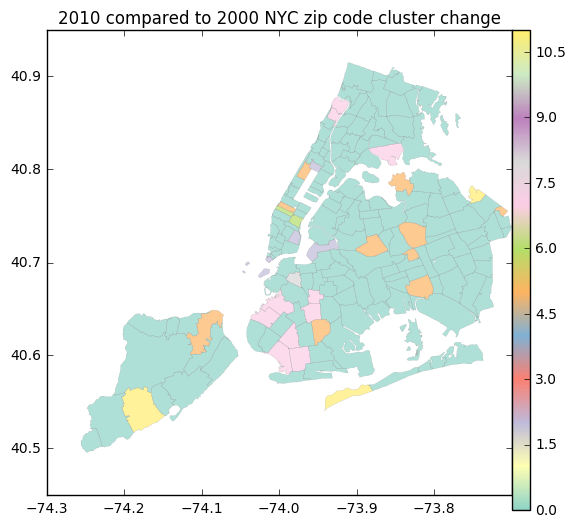

In [664]:
choropleth(df = zip_2000 , column = 'label_c', cm='Set3',
           title = '2010 compared to 2000 NYC zip code cluster change',
           c_bar = True)

#### caption: the zipcode shown where is the area changes cluster from 2000 to 2010. These zipcode areas has significant change in the features: population , median age, income, white people percentage, business. From which cluster in 2000 change to which cluster in 2010, can be referred in dataframe below.

In [620]:
b = [[0,1,2,3],[4,0,5,6],[7,8,0,9],[10,11,12,0]]
color = pd.DataFrame(b)
color.index.name = '2000 cluster'
color.columns.name = '2010 cluster'
color

2010 cluster   0   1   2  3
2000 cluster               
0              0   1   2  3
1              4   0   5  6
2              7   8   0  9
3             10  11  12  0

In [621]:
zip_2000['zip'].groupby(zip_2000['label_c']).count()

label_c
0     157
2       3
5      10
6       2
7      10
8       1
11      3
Name: zip, dtype: int64

#### So there is only 6 types of change at zipcode level.


In [626]:
change = {2:[0,2],
          5:[1,2],
          6:[1,3],
          7:[2,0],
          8:[2,1],
          11:[3,1]}

#### calulate pearson correlation by features and by cluster to find out significantly changed features

In [749]:
def cal_pear(feature, df_1,df_2):
    """
    Calculate pearson correlation of featrues in 2000 and 2010
    feature: population, median age, income, white percentage, business
    df_1: 2000 data 
    df_2: 2010 data
    """
    np.random.seed(12345)
    for i in range(4):
        for j in range(4):
            df1 = df_1[df_1['label']== i][feature]
            df2 = df_2[df_2['label']== j][feature]
            
            leng = min(len(df1),len(df2))
            df1 = np.sort(np.random.choice(df1,leng))
            df2 = np.sort(np.random.choice(df2,leng))
            
            print '2000 cluster:',i,'2010 cluster:',j
            print 'data count',leng
            print scipy.stats.pearsonr(df1,df2),'\n'
                                           

In [690]:
features = ['population','median_age','white_percentage',
            'income','business']

In [750]:
cal_pear(feature = 'business',df_1 = zip_2000,df_2 = zip_2010)

2000 cluster: 0 2010 cluster: 0
data count 44
(0.91557067899326239, 3.2268205556027454e-18) 

2000 cluster: 0 2010 cluster: 1
data count 44
(0.80910461173197856, 3.0067752249364614e-11) 

2000 cluster: 0 2010 cluster: 2
data count 44
(0.89141228798710592, 5.000806473991473e-16) 

2000 cluster: 0 2010 cluster: 3
data count 19
(0.83741075768948314, 7.7292035419590425e-06) 

2000 cluster: 1 2010 cluster: 0
data count 49
(0.79455343547470403, 9.4367121534908287e-12) 

2000 cluster: 1 2010 cluster: 1
data count 45
(0.97266192300519516, 6.7346356639054854e-29) 

2000 cluster: 1 2010 cluster: 2
data count 57
(0.91913339167058594, 6.5172284064531247e-24) 

2000 cluster: 1 2010 cluster: 3
data count 19
(0.89863291338490092, 1.7310899331911632e-07) 

2000 cluster: 2 2010 cluster: 0
data count 49
(0.82408012710323197, 3.490986495369103e-13) 

2000 cluster: 2 2010 cluster: 1
data count 45
(0.87354999355109886, 4.9204372804230989e-15) 

2000 cluster: 2 2010 cluster: 2
data count 71
(0.9657239500564

In [751]:
for i in features[:-1]:
    print i
    cal_pear(feature = i, df_1 = data_2000, df_2 = data_2010)


population
2000 cluster: 0 2010 cluster: 0
data count 807
(0.95703641734067313, 0.0) 

2000 cluster: 0 2010 cluster: 1
data count 466
(0.97262434306839785, 3.1573472818501113e-296) 

2000 cluster: 0 2010 cluster: 2
data count 712
(0.96562965319470362, 0.0) 

2000 cluster: 0 2010 cluster: 3
data count 124
(0.97350408420728629, 4.9291748618353618e-80) 

2000 cluster: 1 2010 cluster: 0
data count 376
(0.86176998137525396, 2.8069339979248361e-112) 

2000 cluster: 1 2010 cluster: 1
data count 376
(0.98785641317755157, 1.553725676125762e-304) 

2000 cluster: 1 2010 cluster: 2
data count 376
(0.97830623150541285, 8.4376332898268508e-258) 

2000 cluster: 1 2010 cluster: 3
data count 124
(0.98631338493825205, 2.2841814455620101e-97) 

2000 cluster: 2 2010 cluster: 0
data count 682
(0.95715776661102869, 0.0) 

2000 cluster: 2 2010 cluster: 1
data count 466
(0.97828602130358755, 2.7577262153920858e-319) 

2000 cluster: 2 2010 cluster: 2
data count 682
(0.99341122426069284, 0.0) 

2000 cluster: 2 

 According to scipy.stats.pearsonr docstring. The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from given datasets. If data is more than 500,than pvalue would be reliable. 
Here data counts are not always above 500,so I don't set the pvalue threshold.

#### All features pvalue is very small,means they have very strong pearson correlation. 

#### Most of correlation is close to 1. I set 0.8 as threshold . If correlation is less than 0.8, then I regard that features changes significantly.

In [761]:
f_change = {'business' : [[1,0],[3,1],[3,2]],
           'white_percentage' : [[1,2],[2,3],[3,2],[3,3]],
           'income' : [[2,3],[3,2]]}

In [760]:
i = 'white_percentage'
c = len(f_change[i])
#fig = plt.figure(figsize = (20,6*c))
for k in range(c):
    print f_change[i][k][0]

1
2
3


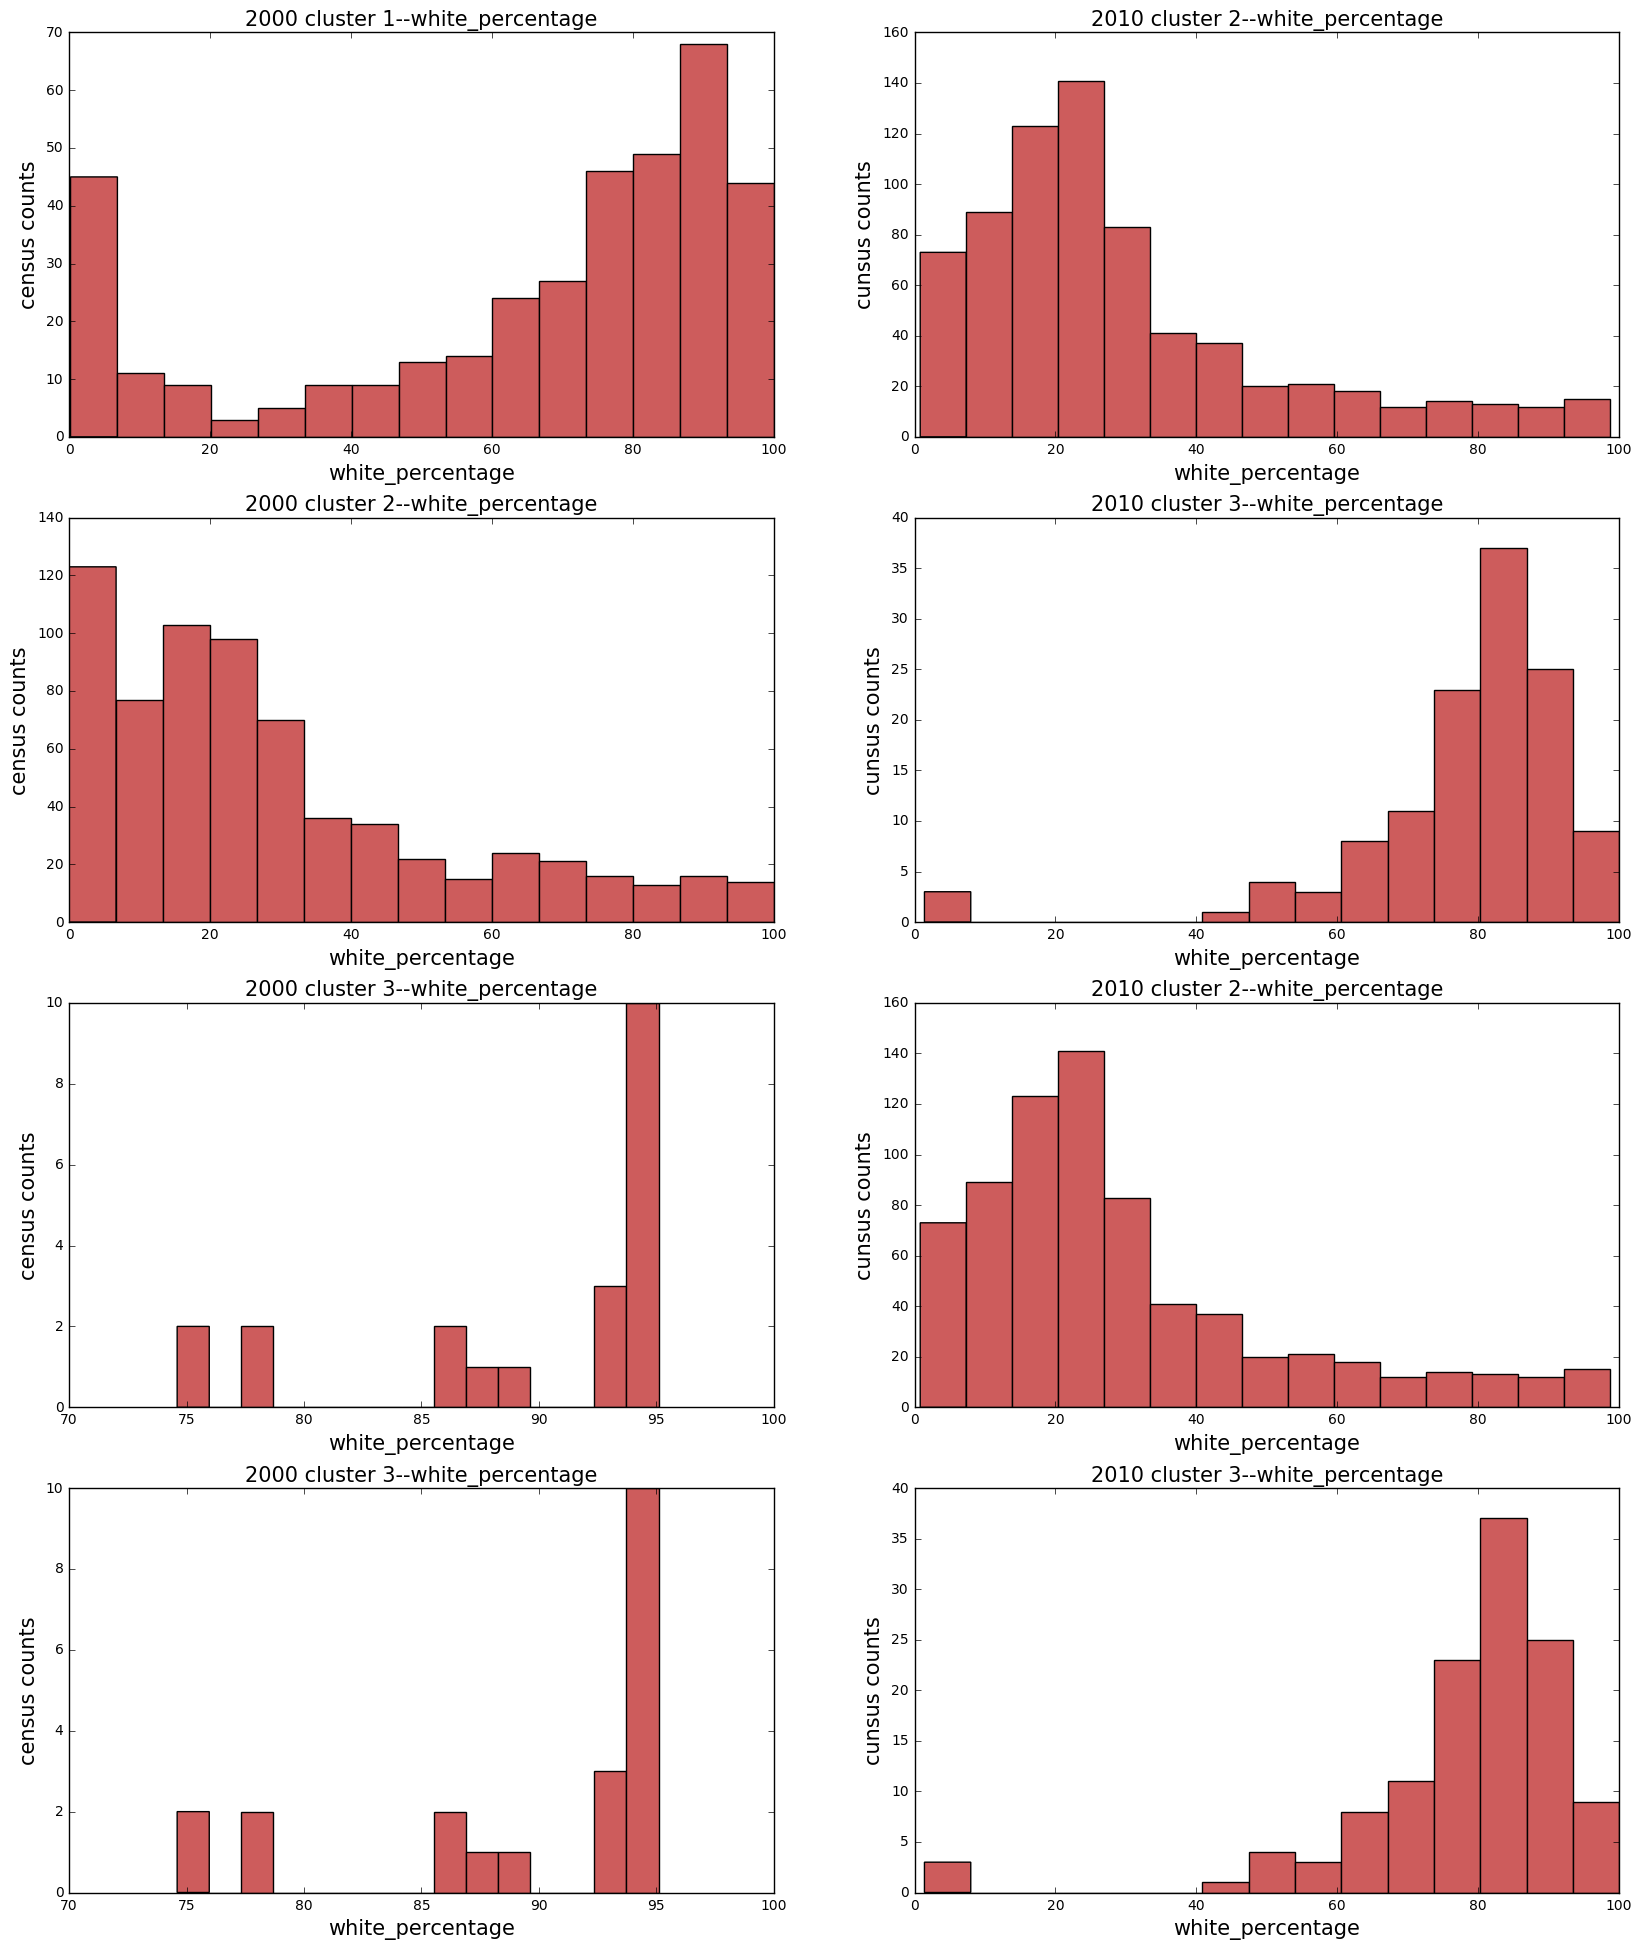

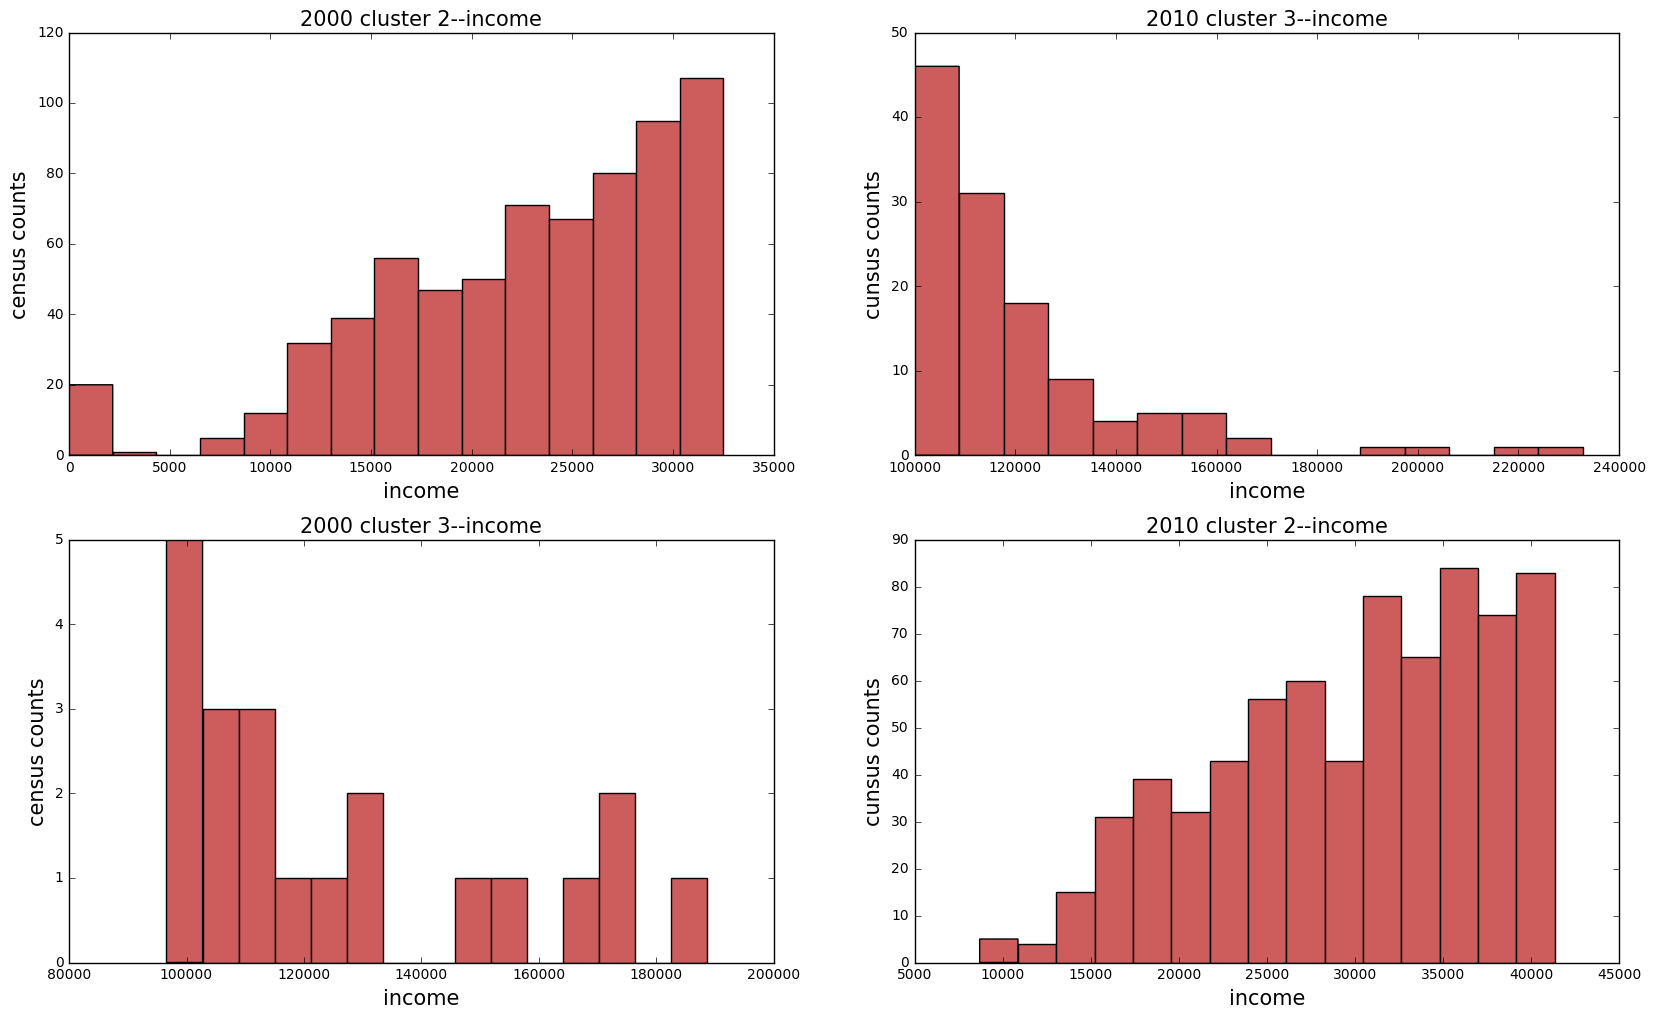

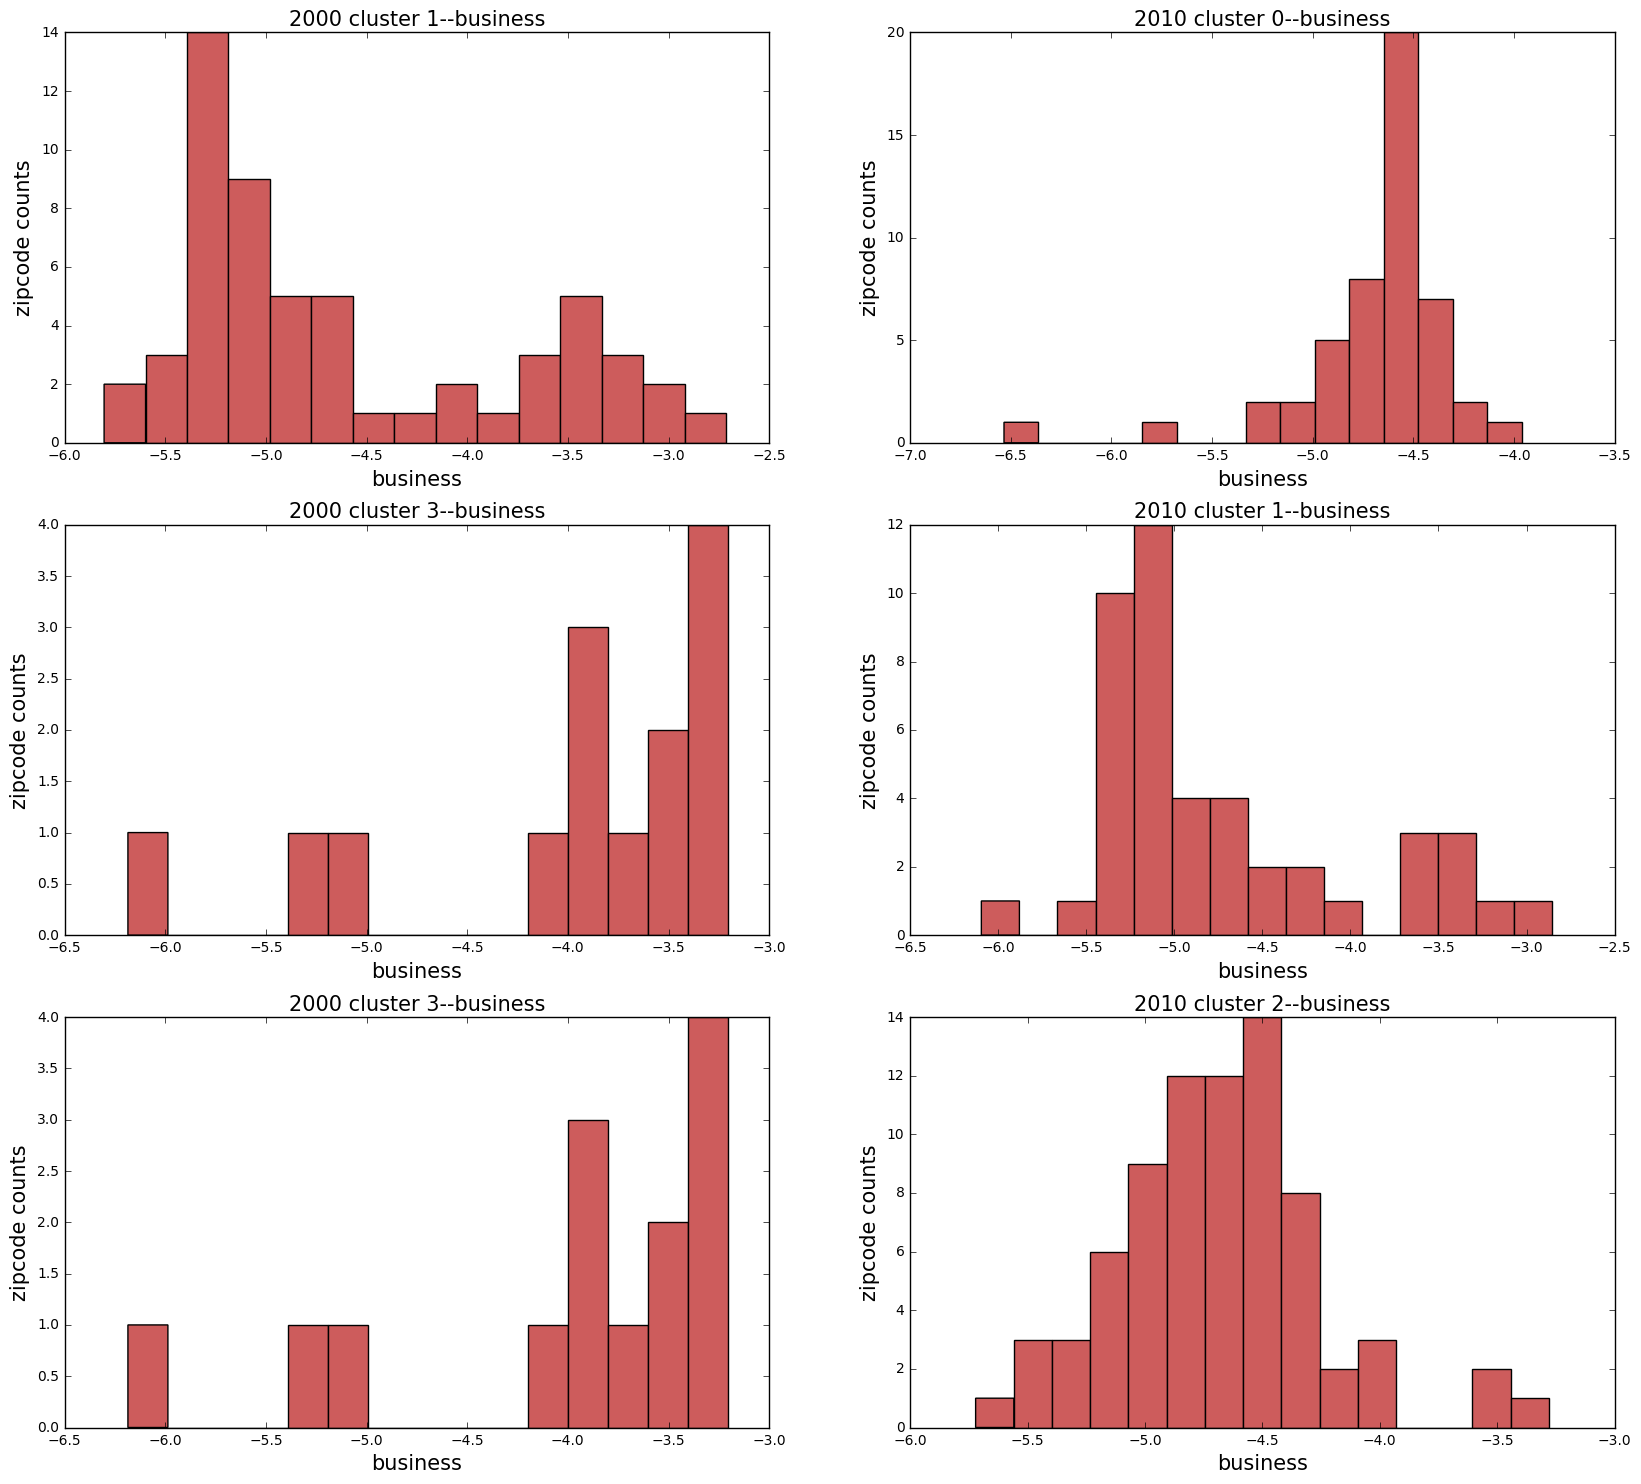

In [762]:
for i in ['white_percentage','income']:
    
    
    c = len(f_change[i])
    fig = plt.figure(figsize = (20,6*c))
    for k in range(c):
        ax1 = fig.add_subplot(c,2,(k * 2 + 1))
        df1 = data_2000[data_2000['label'] == f_change[i][k][0]][i]      
        df2 = data_2010[data_2010['label'] == f_change[i][k][1]][i]

    
        plt.hist(df1 , 15 , color = 'indianred')     
        plt.xlabel('%s'%i ,fontsize = 15)
        plt.ylabel('census counts',fontsize = 15 )    
        plt.title( '%s %d--%s'%('2000 cluster',f_change[i][k][0] , i),
              fontsize = 15) 
        
        ax2 = fig.add_subplot(c, 2, (k * 2 + 2))
        plt.hist(df2 , 15 , color = 'indianred')     
        plt.xlabel('%s'%i ,fontsize = 15)
        plt.ylabel('cunsus counts',fontsize = 15 )    
        plt.title( '%s %d--%s'%('2010 cluster', f_change[i][k][1], i),
              fontsize = 15)    

i = 'business'
c = len(f_change[i])
fig = plt.figure(figsize = (20,6*c))
for k in range(c):
    ax1 = fig.add_subplot(c,2,(k * 2 + 1))
    df1 = zip_2000[zip_2000['label'] == f_change[i][k][0]][i]      
    df2 = zip_2010[zip_2010['label'] == f_change[i][k][1]][i]

    
    plt.hist(df1 , 15 , color = 'indianred')     
    plt.xlabel('%s'%i ,fontsize = 15)
    plt.ylabel('zipcode counts',fontsize = 15 )    
    plt.title( '%s %d--%s'%('2000 cluster',f_change[i][k][0] , i),
              fontsize = 15) 
        
    ax2 = fig.add_subplot(c, 2, (k * 2 + 2))
    plt.hist(df2 , 15 , color = 'indianred')     
    plt.xlabel('%s'%i ,fontsize = 15)
    plt.ylabel('zipcode counts',fontsize = 15 )    
    plt.title( '%s %d--%s'%('2010 cluster', f_change[i][k][1], i),
              fontsize = 15)

#### caption :  Each row is a pair. They are of different clusters with significant difference in the features. 
### Population and median age  are all not significantly different, as their pearson correlation are quite high. Business , white percentage and income are more influential.

For cluster 1 in 2000 and cluster 0 in 2010, business are significantly different.

For cluster 1 in 2000 and cluster 2 in 2010, white people percentage are significantly different.

For cluster 2 in 2000 and cluster 3 in 2010, white people percentage and income are significantly different.

For cluster 3 in 2000 and cluster 1 in 2010, business are significantly different.

For cluster 3 in 2000 and cluster 2 in 2010, business,white people percentage and income are significantly different.

## 13) comment

#### the weakness of the analysis:
1.demogranpic and income data is at  census tract level, business data is at zipcode level. In order to merge these data, I used controid to represent the census tract ,and if zipcode polygon contains the controid , I will assign the census tract to  the zipcode. However , this can cause problems, if come census tract belongs to two or more zip code in reality,  I just assign the whole census tract to where it centroid belongs to.
Additionally, there are three census tracts' centroids are not contained in any zipcode polygon. Those census tract is at water front, are concave shape. I guess the reason is  their centroids are in water, not in the border of zipcode.

2.Pearson correlation applys to large volumn of data , the data of census tract here is quite few. So the reliability of pearson correlation is unsure. And it requires two data have same length. But in different cluster , the census tracts number are different, so i just chose randomly ,to make sure the data are of same length.

3.I  use census tract 2010 shapefile for both 2010 and 2000. If the census tract scope is revised between 2010 and 2000, this will bring errors.

4.In order to find which features change significantly, and which features have strong correlation with business. The better way is to put business density in cluster, or business difference in 10 years in cluster. And compare features of different clusters. However business data is at zipcode level, at most 263 data, after group into 4 clusters, each cluster has aroud 60 data. As data amount is small, then pearson correlation is not very reliable tool.